(36662, 56)


/var/folders/2p/rk52006d4bg4_1ss6d7zs10r0000gn/T/ipykernel_48175/95336430.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  X = torch.tensor(X, dtype=torch.float32)


X_train shape: torch.Size([21982, 10, 56])
y_train shape: torch.Size([21982, 6, 50])
output size: 50
Train samples 21997
Epoch 0: Train RMSE 0.7399, MAE 0.1173, R^2 0.0434 | Test RMSE 0.8420, MAE 0.1287, R^2 0.0427
Epoch 2: Train RMSE 0.7383, MAE 0.1050, R^2 0.0477 | Test RMSE 0.8415, MAE 0.1168, R^2 0.0440
Epoch 4: Train RMSE 0.7380, MAE 0.1010, R^2 0.0485 | Test RMSE 0.8423, MAE 0.1122, R^2 0.0422
Epoch 6: Train RMSE 0.7349, MAE 0.1204, R^2 0.0563 | Test RMSE 0.8394, MAE 0.1346, R^2 0.0487
Epoch 8: Train RMSE 0.7343, MAE 0.1099, R^2 0.0578 | Test RMSE 0.8394, MAE 0.1229, R^2 0.0487
Epoch 10: Train RMSE 0.7343, MAE 0.1183, R^2 0.0580 | Test RMSE 0.8416, MAE 0.1353, R^2 0.0437
Epoch 12: Train RMSE 0.7337, MAE 0.1164, R^2 0.0595 | Test RMSE 0.8406, MAE 0.1295, R^2 0.0461
Epoch 14: Train RMSE 0.7306, MAE 0.1072, R^2 0.0674 | Test RMSE 0.8398, MAE 0.1210, R^2 0.0478
Epoch 16: Train RMSE 0.7290, MAE 0.1123, R^2 0.0714 | Test RMSE 0.8435, MAE 0.1300, R^2 0.0394
Epoch 18: Train RMSE 0.7261, 

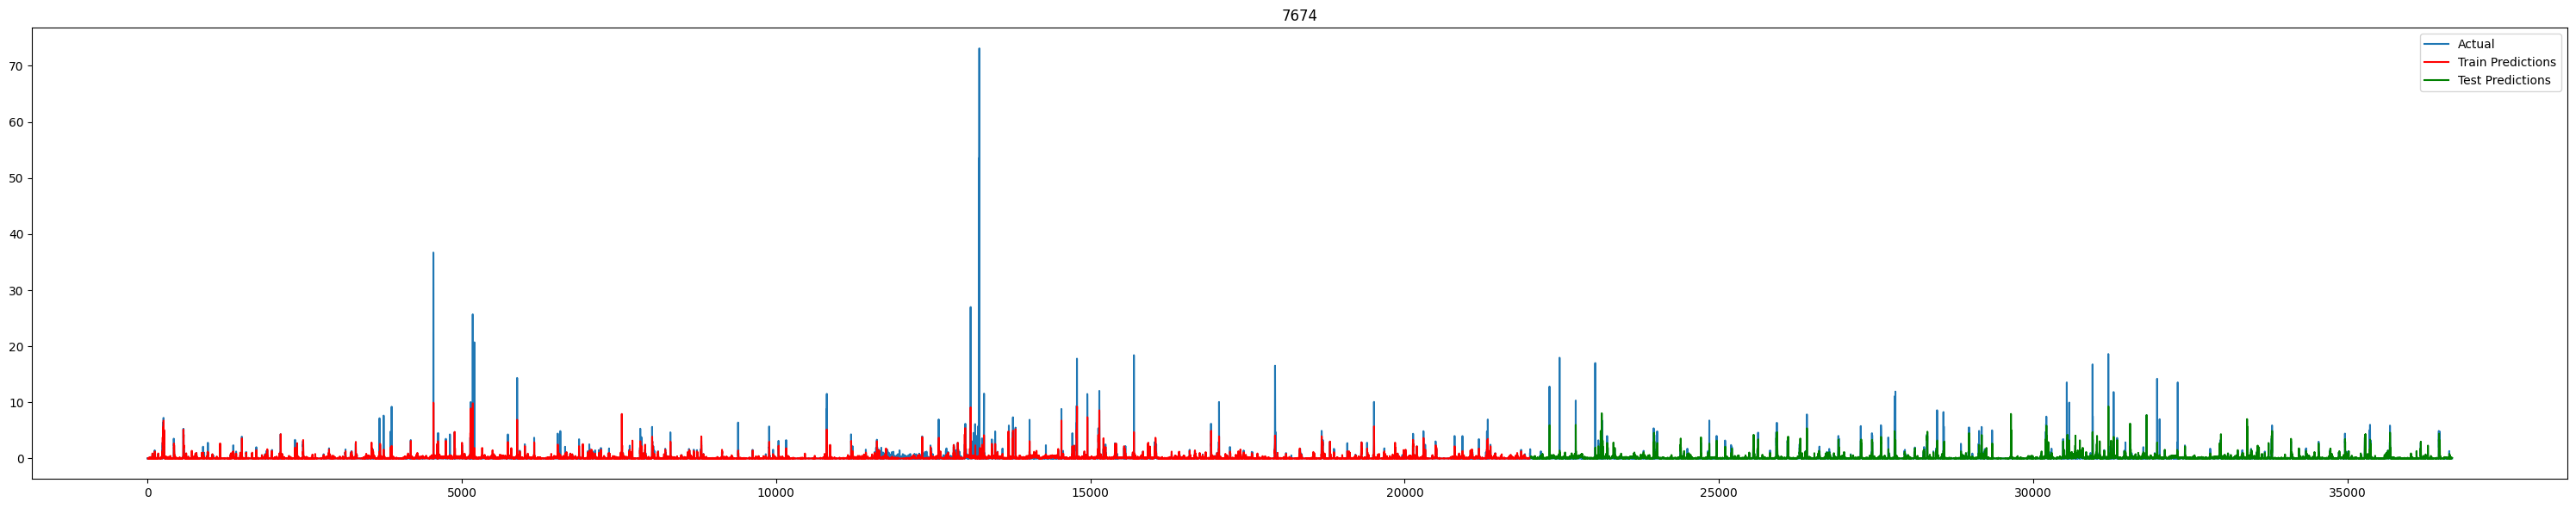

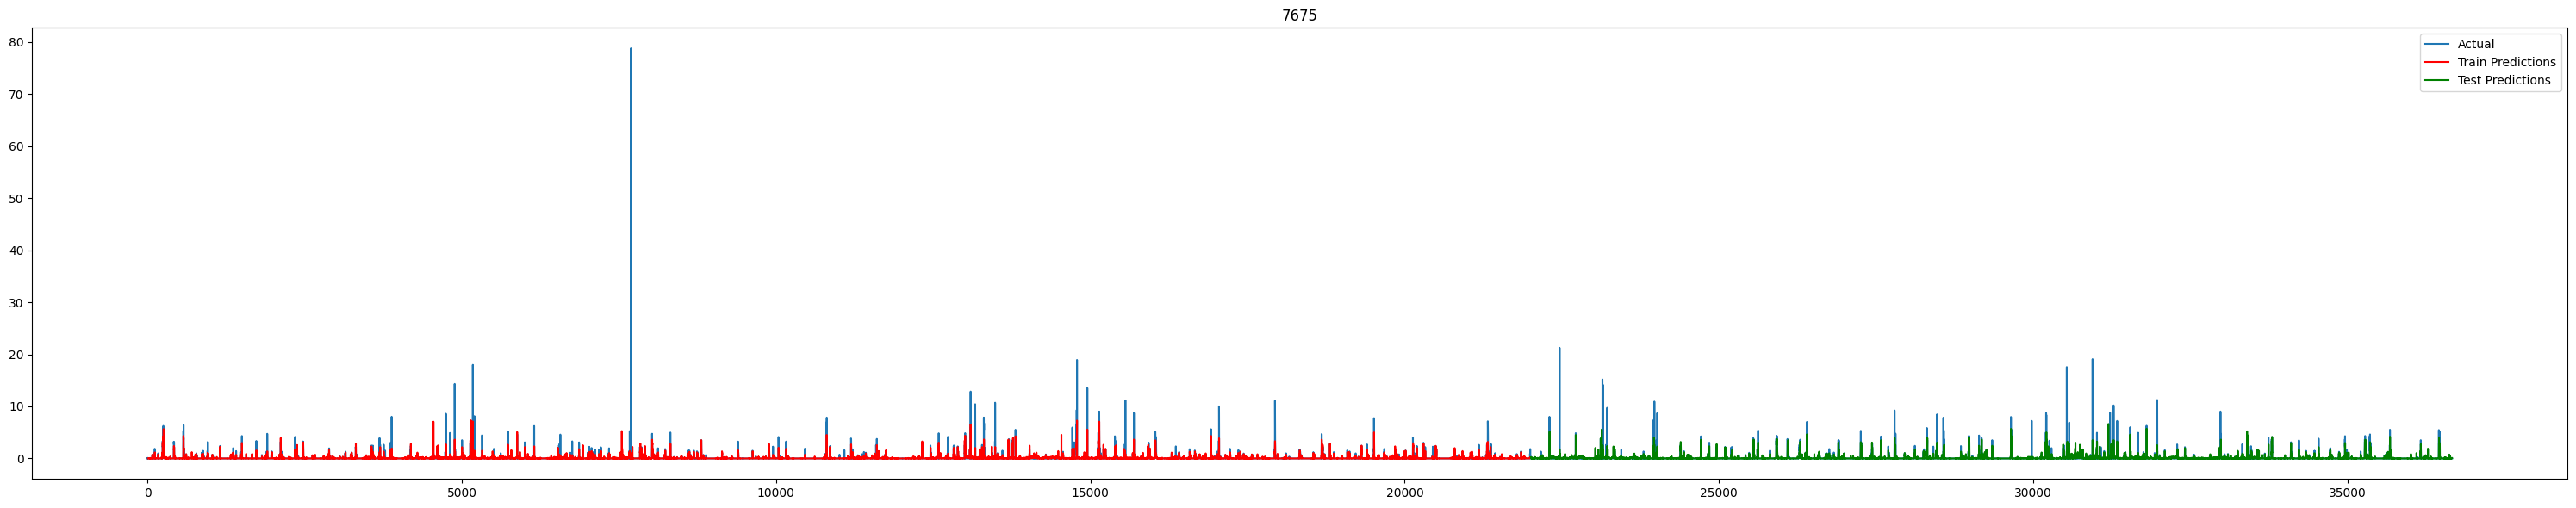

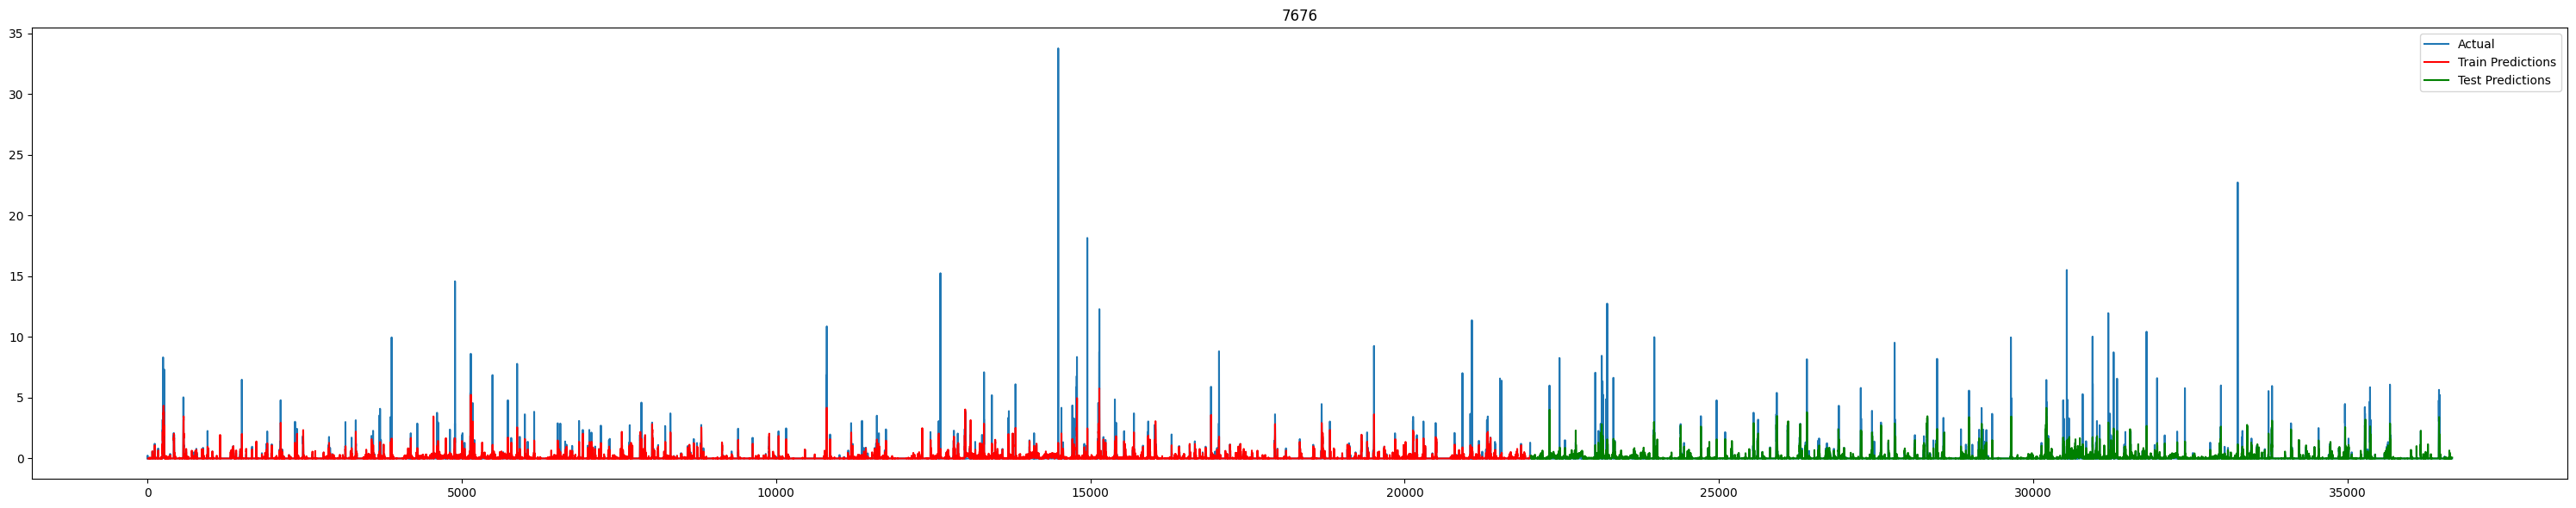

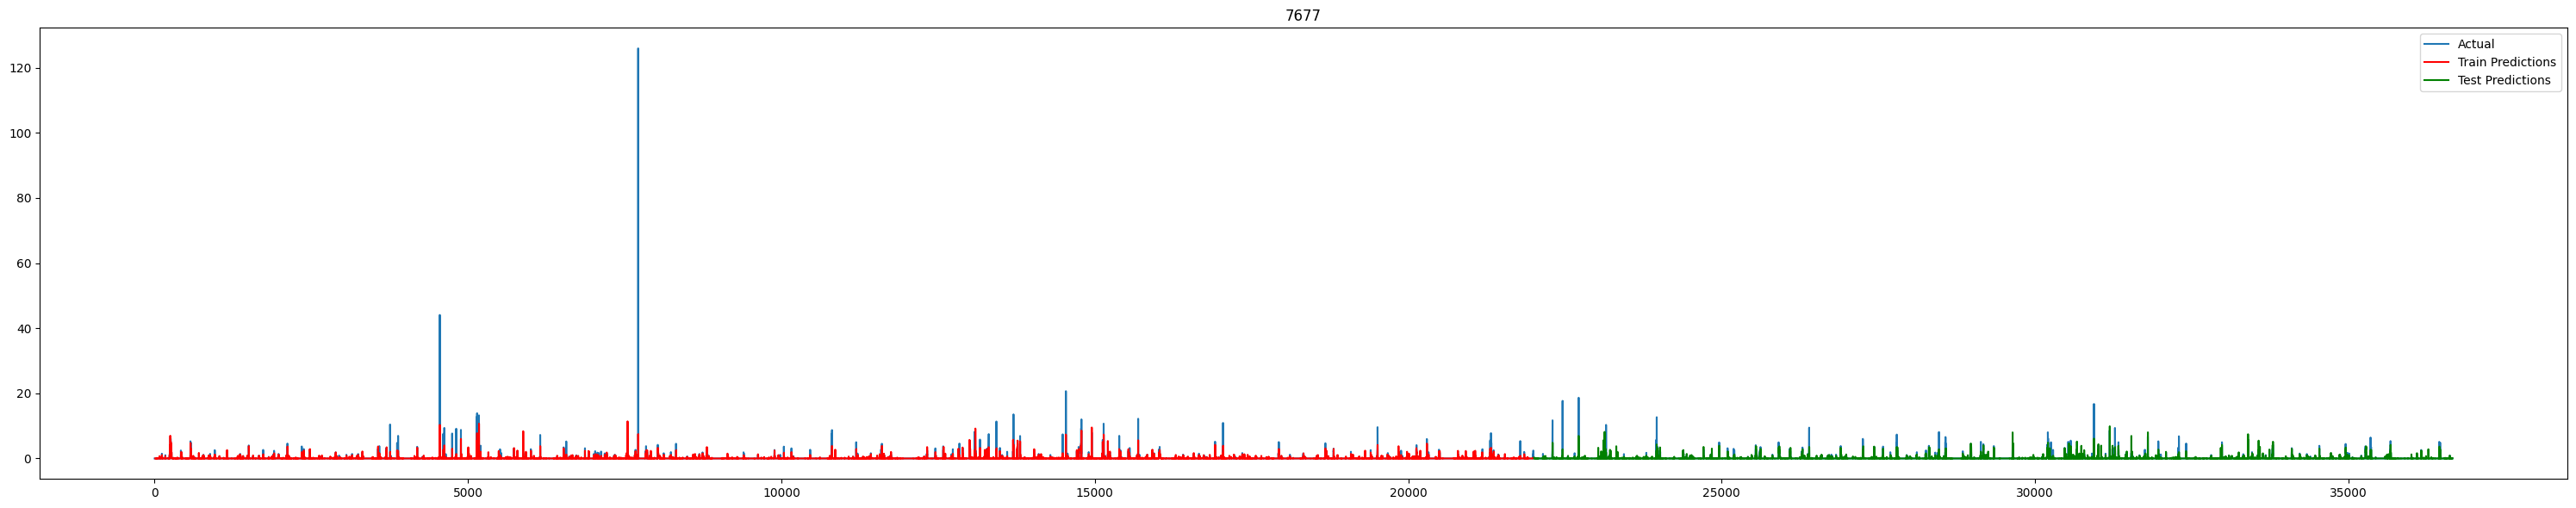

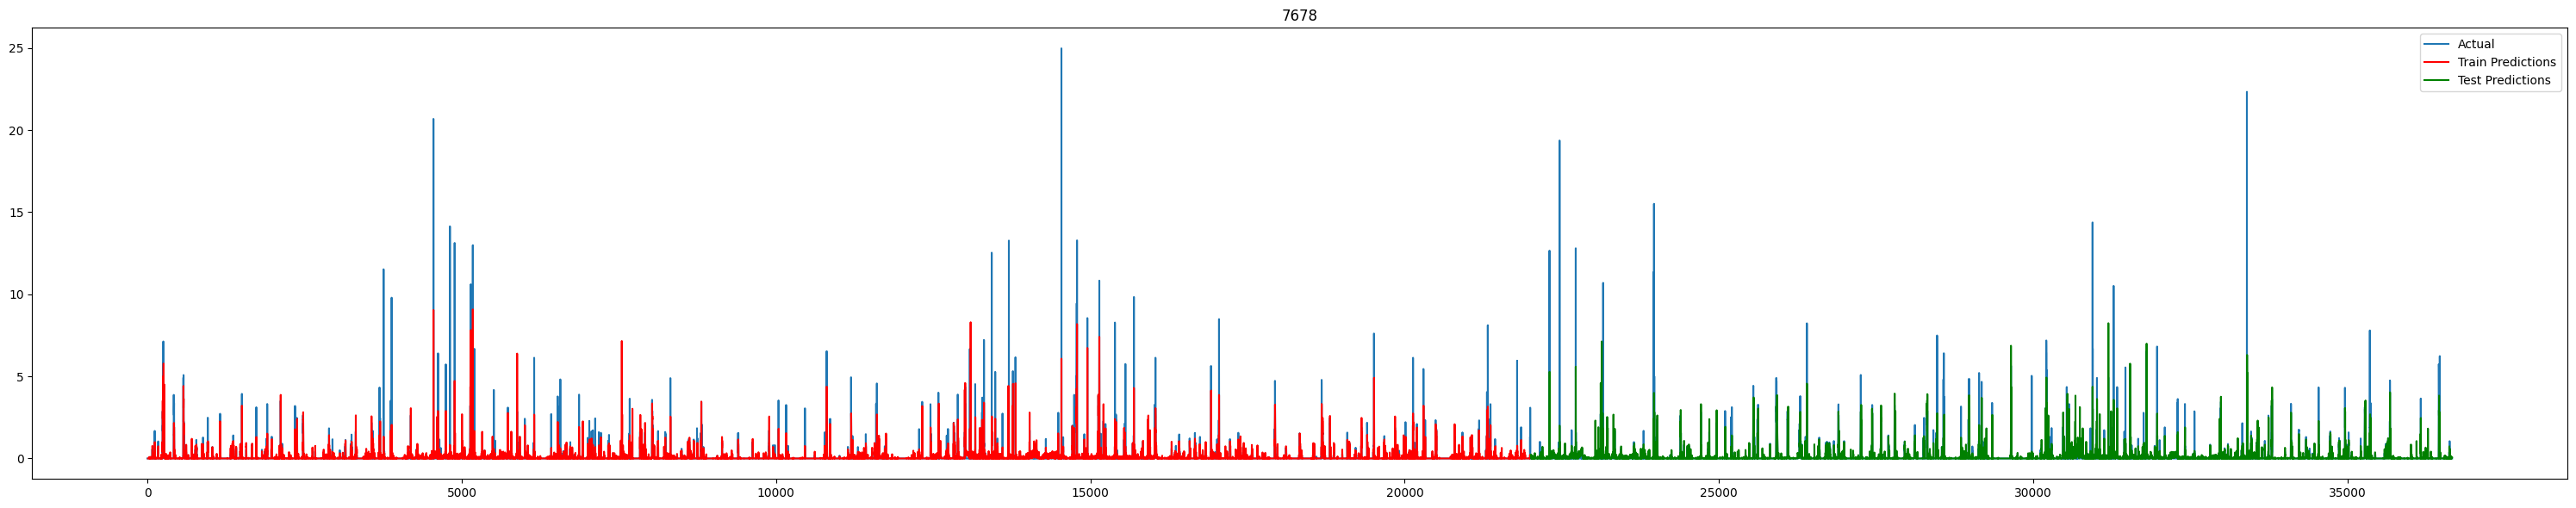

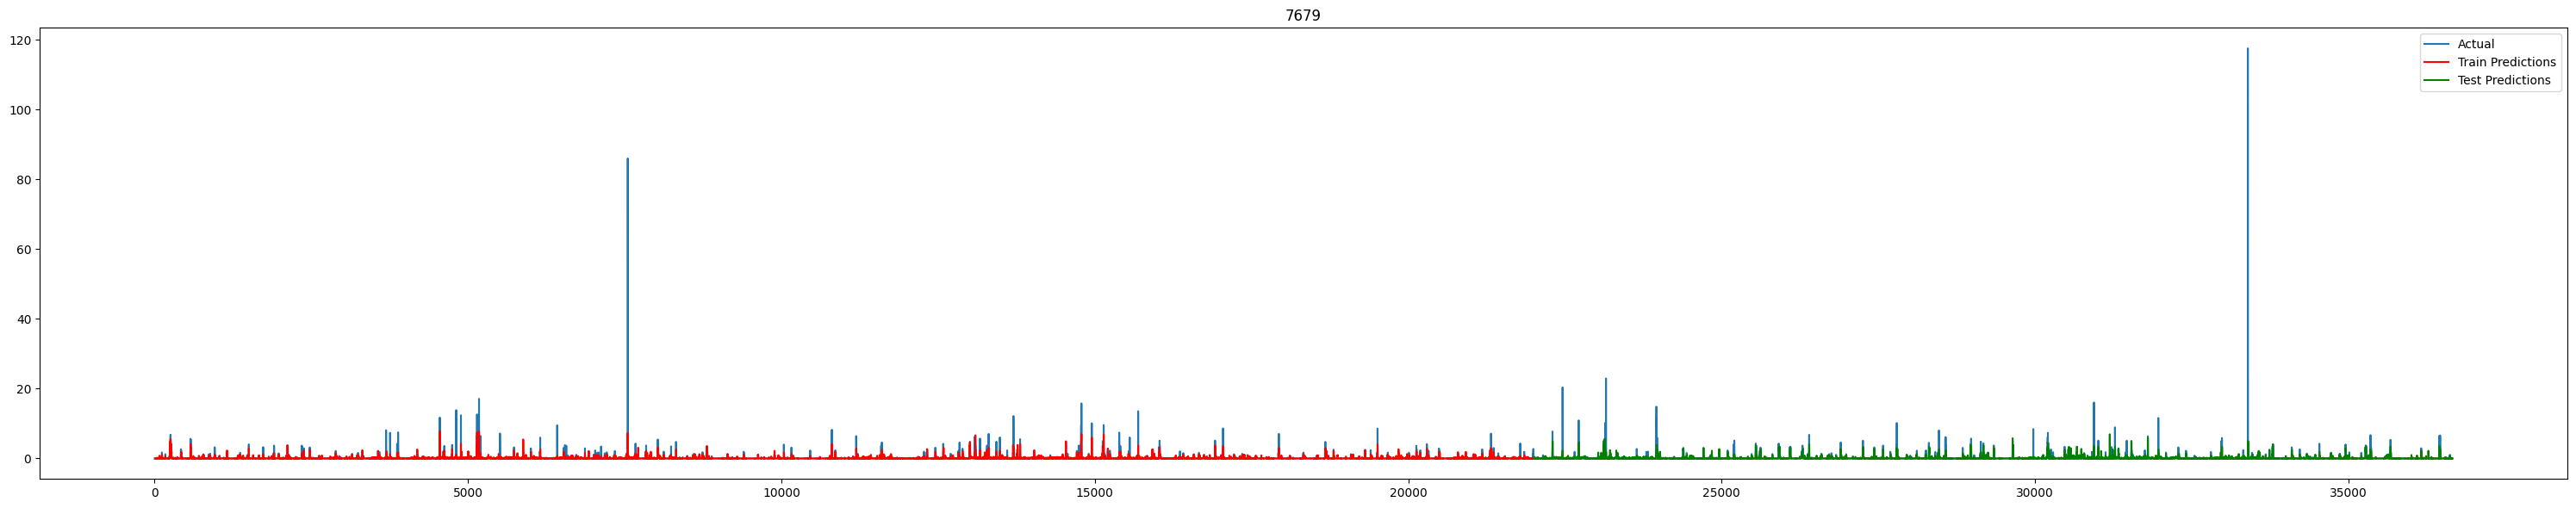

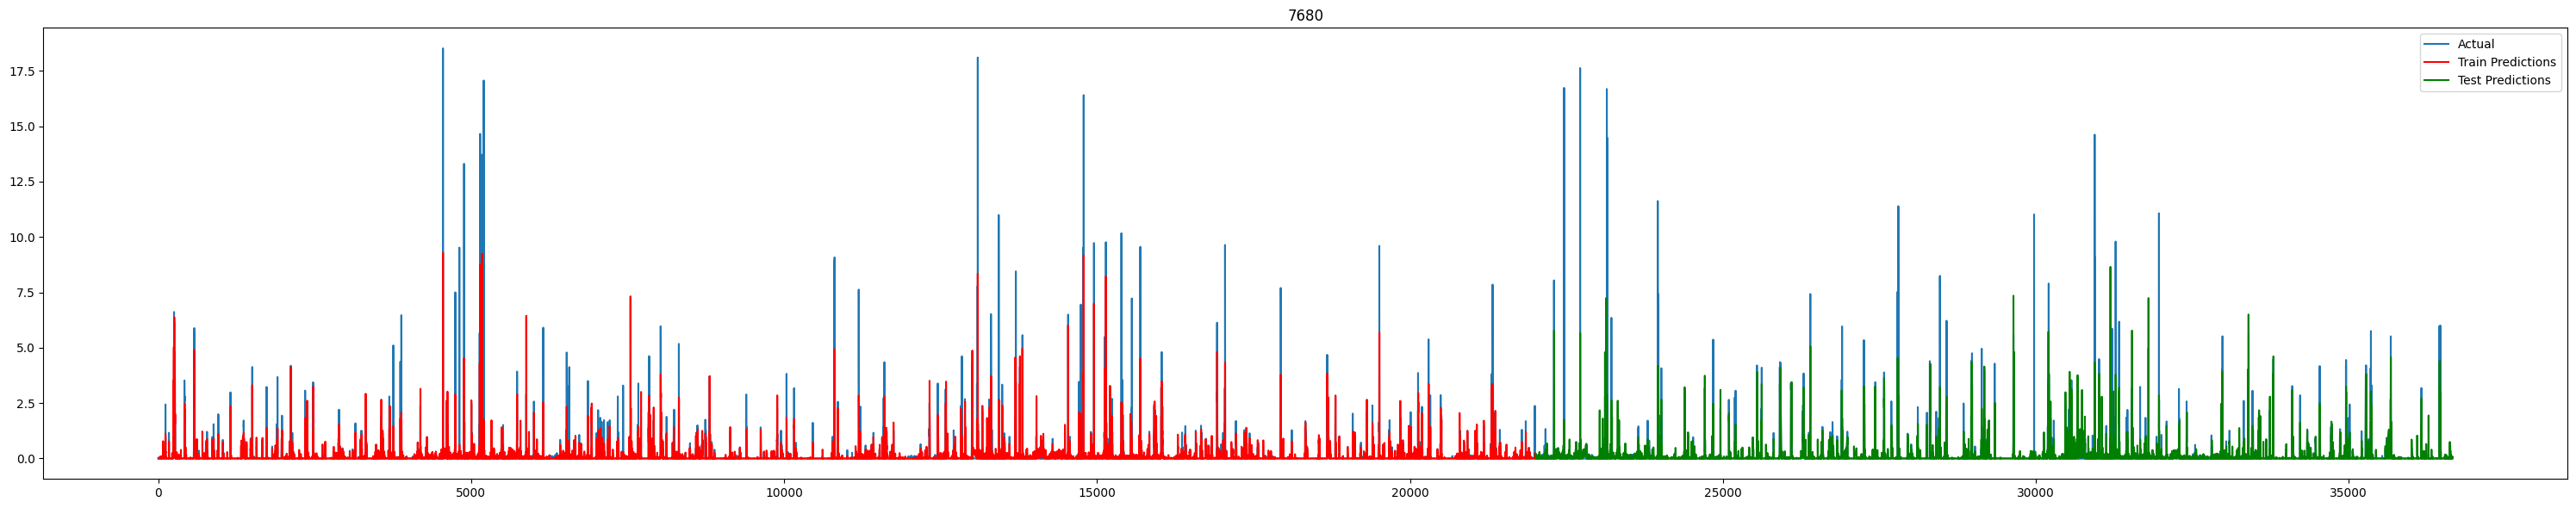

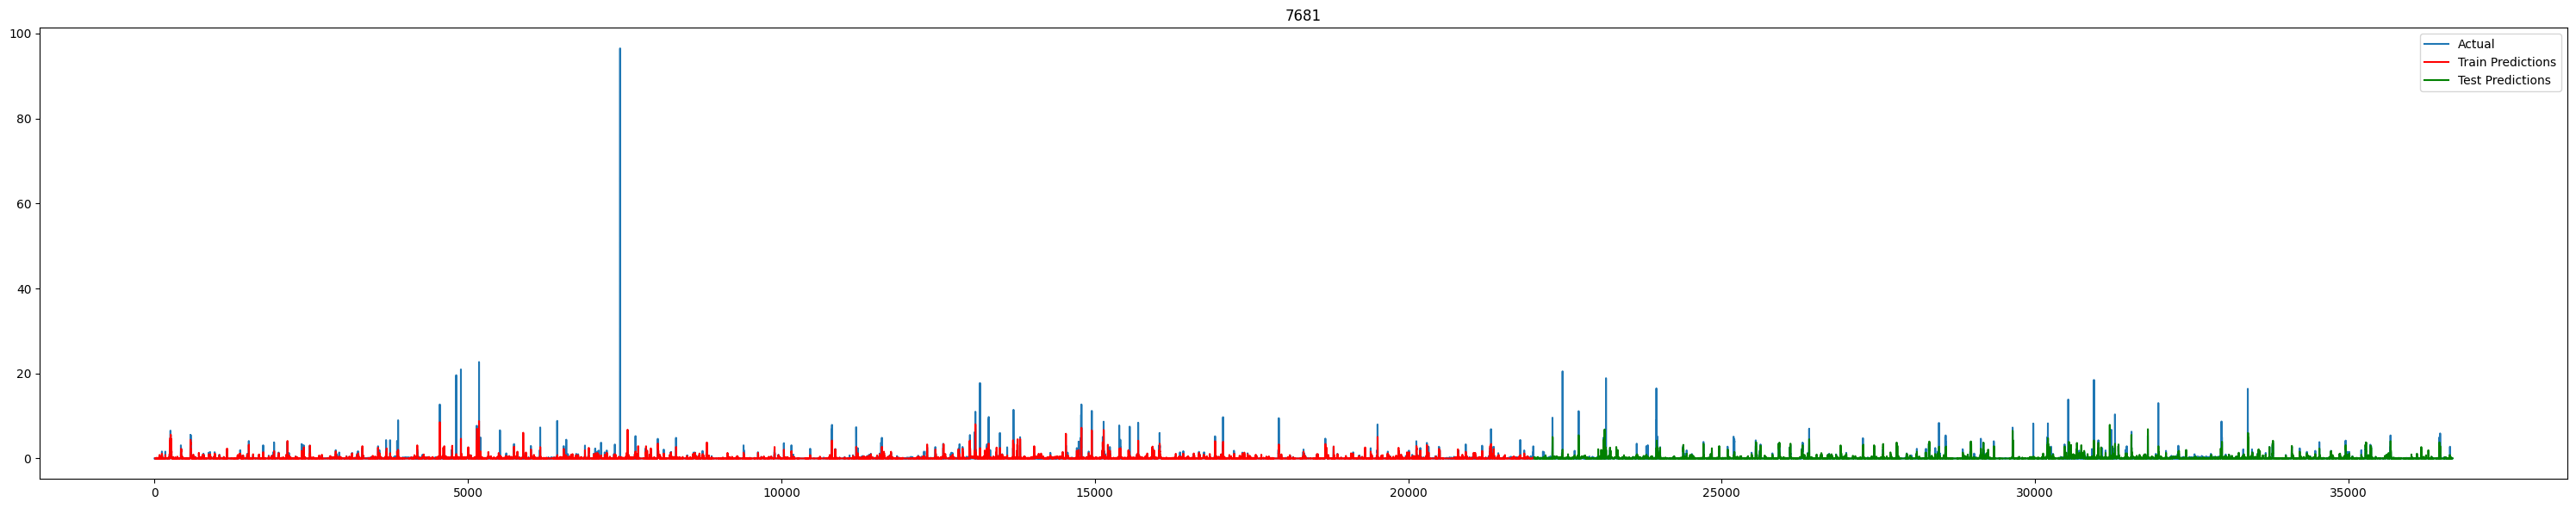

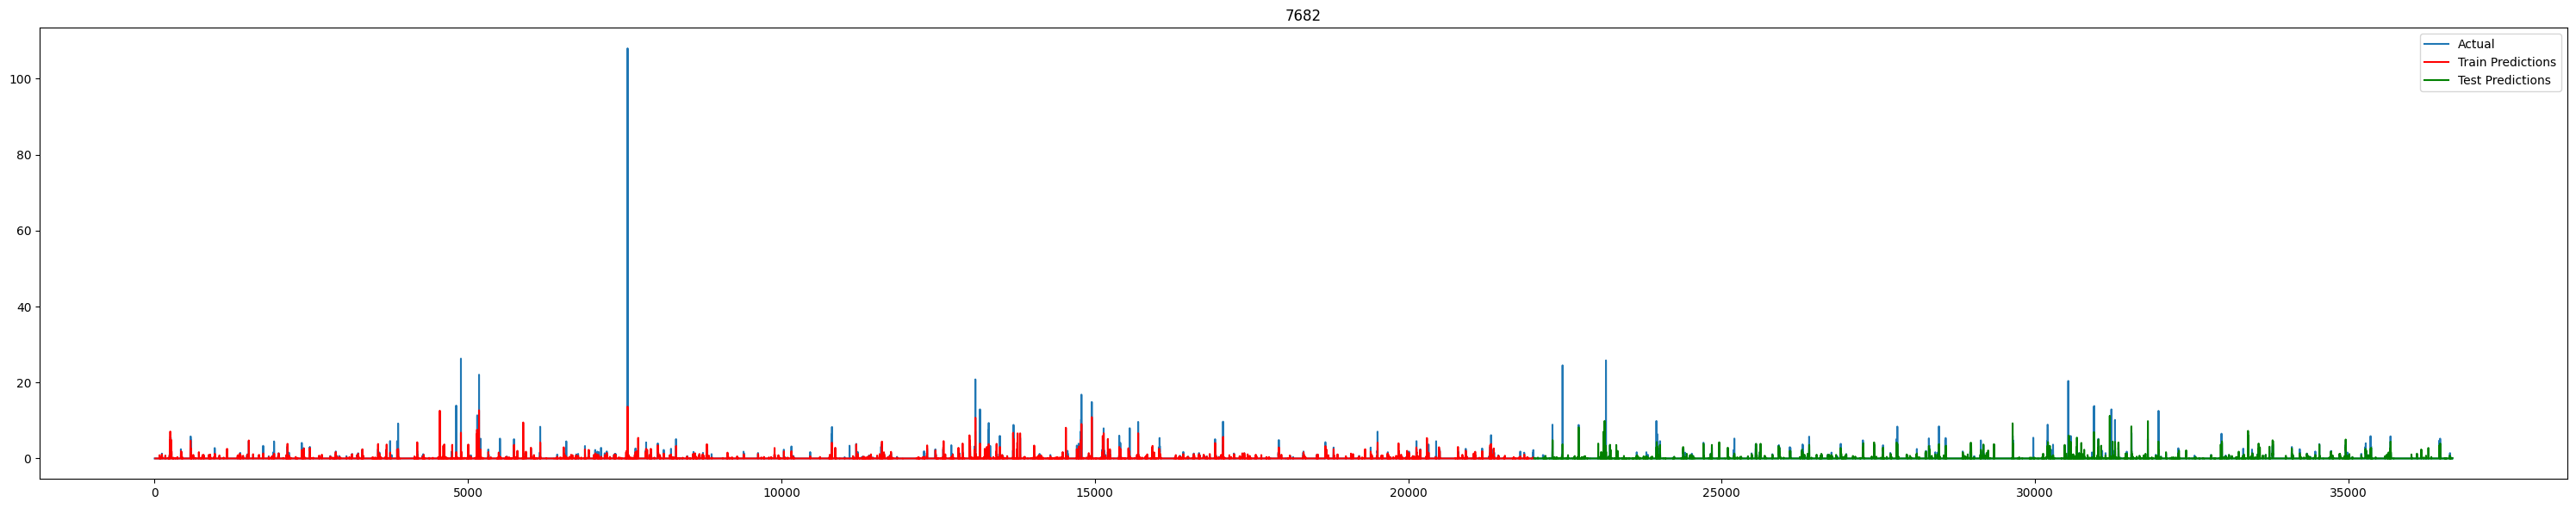

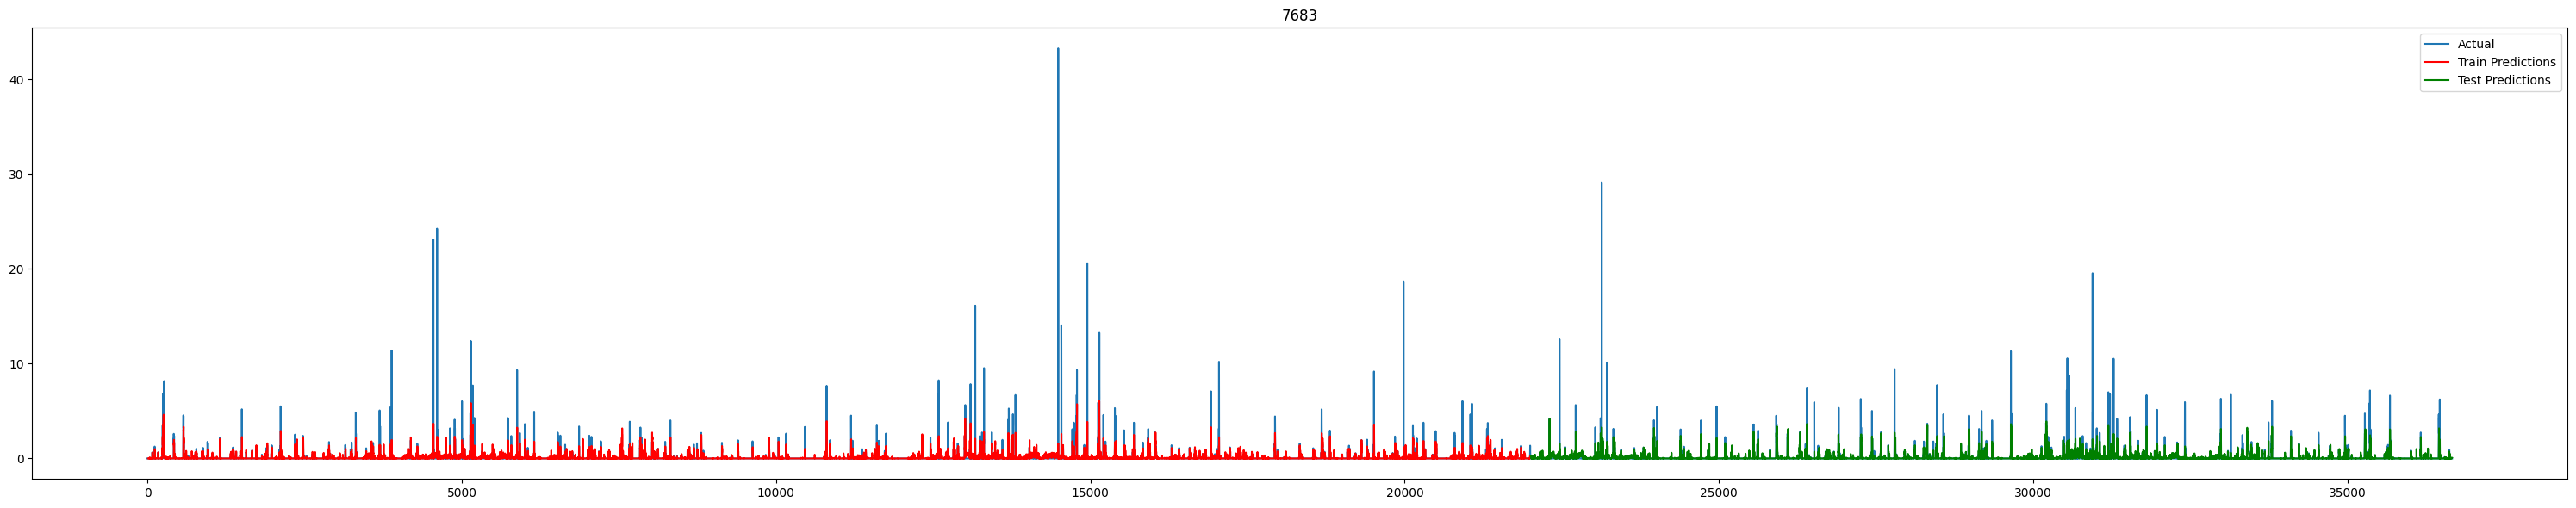

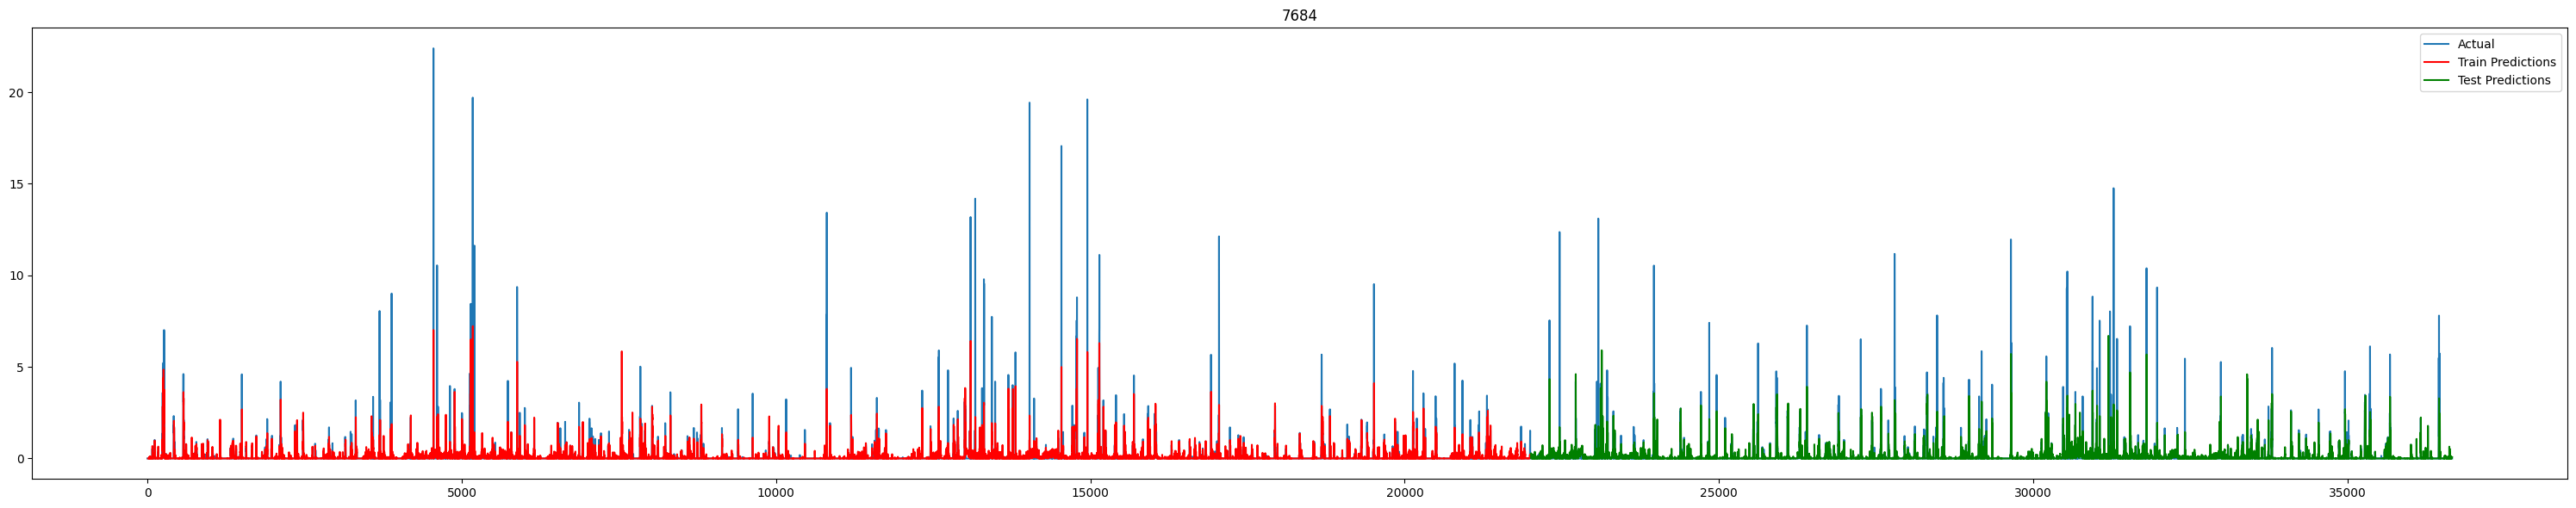

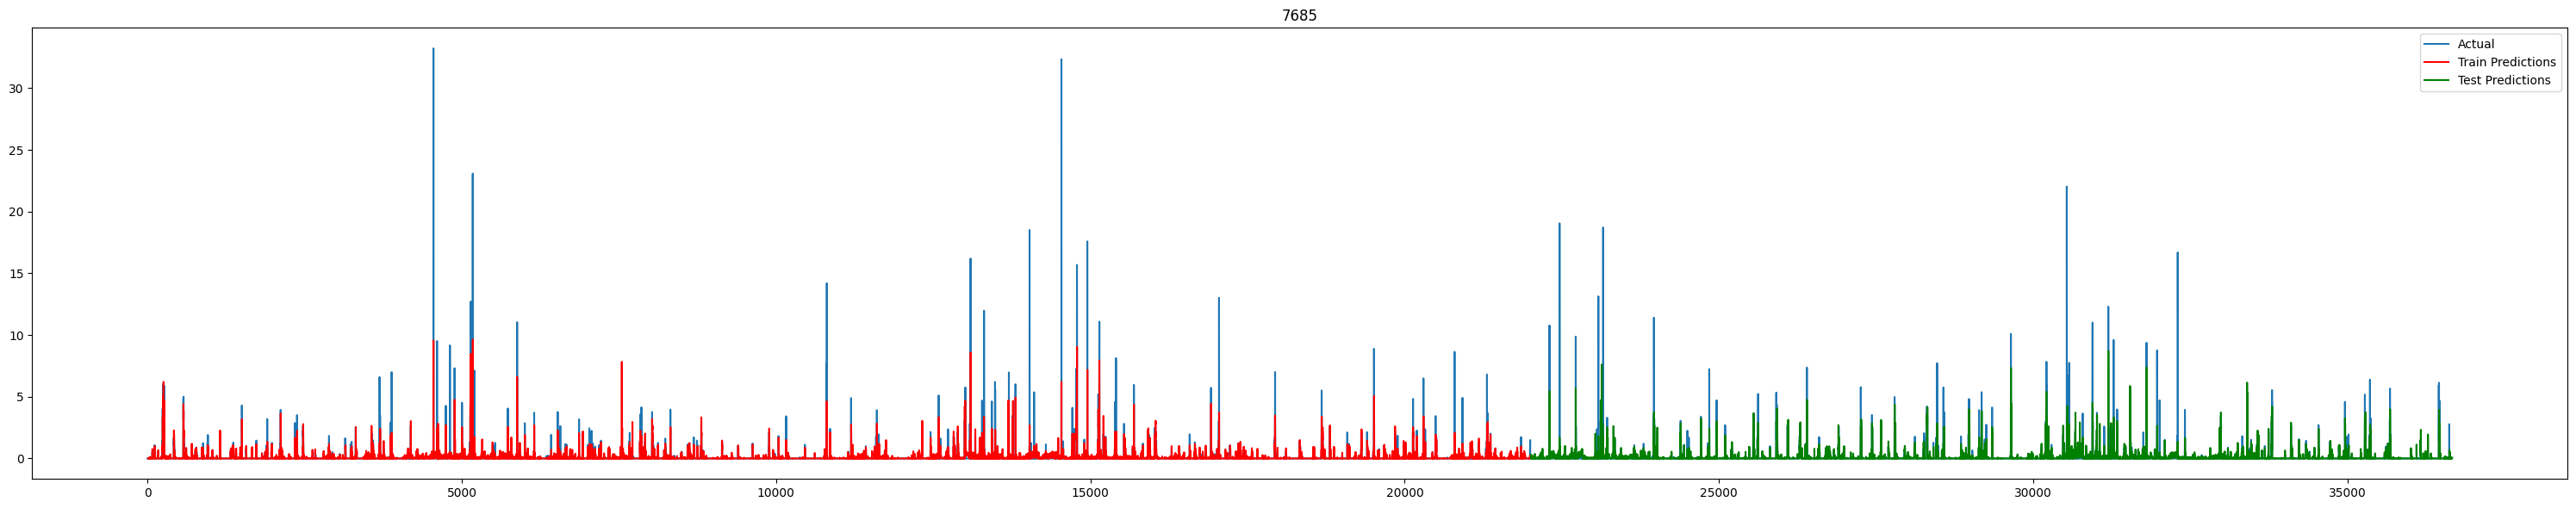

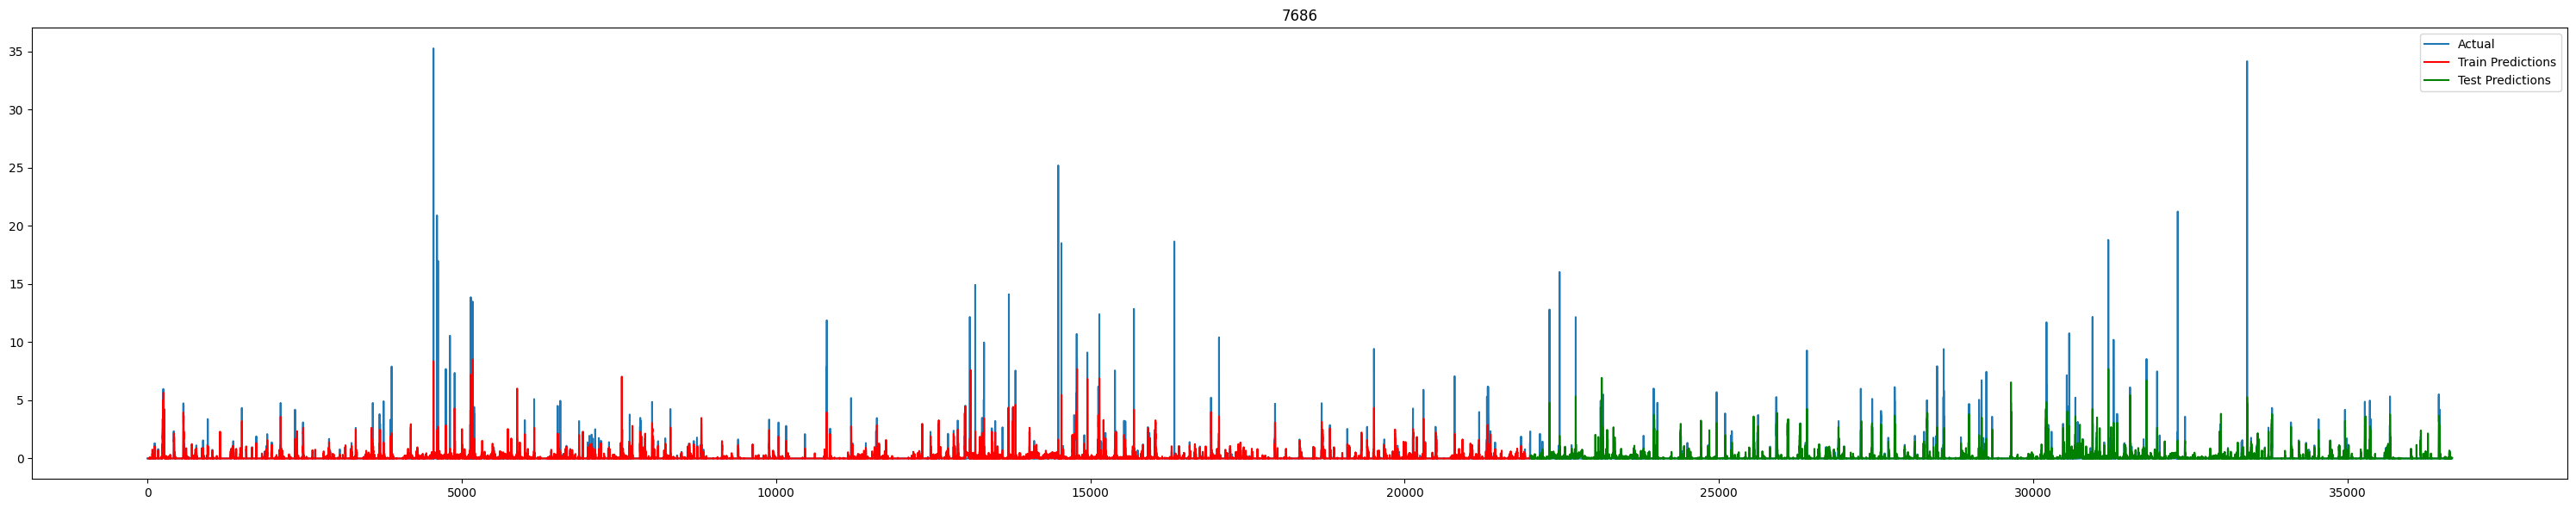

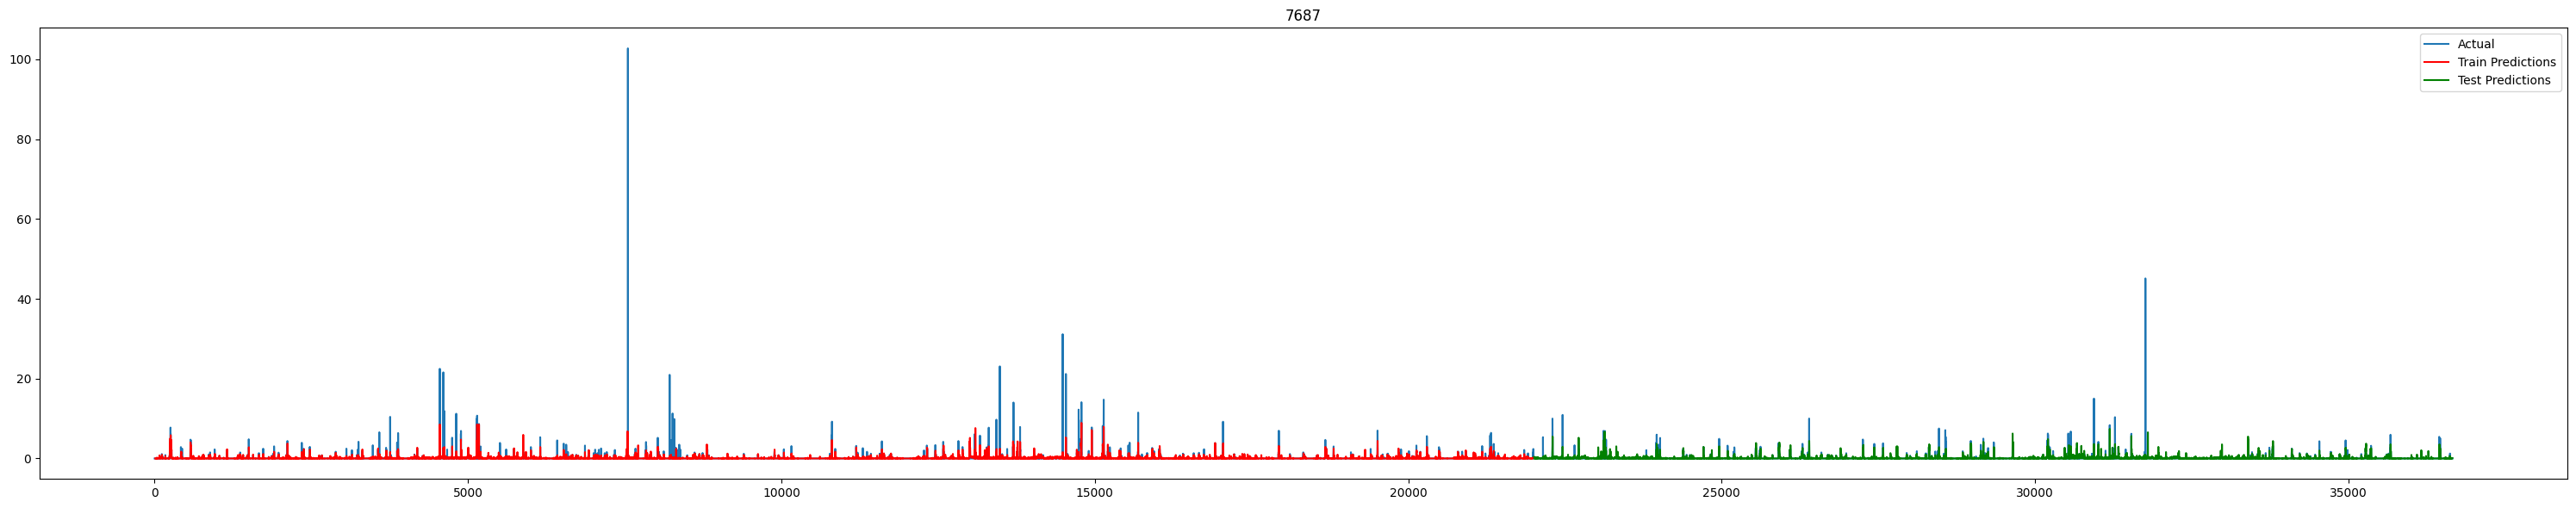

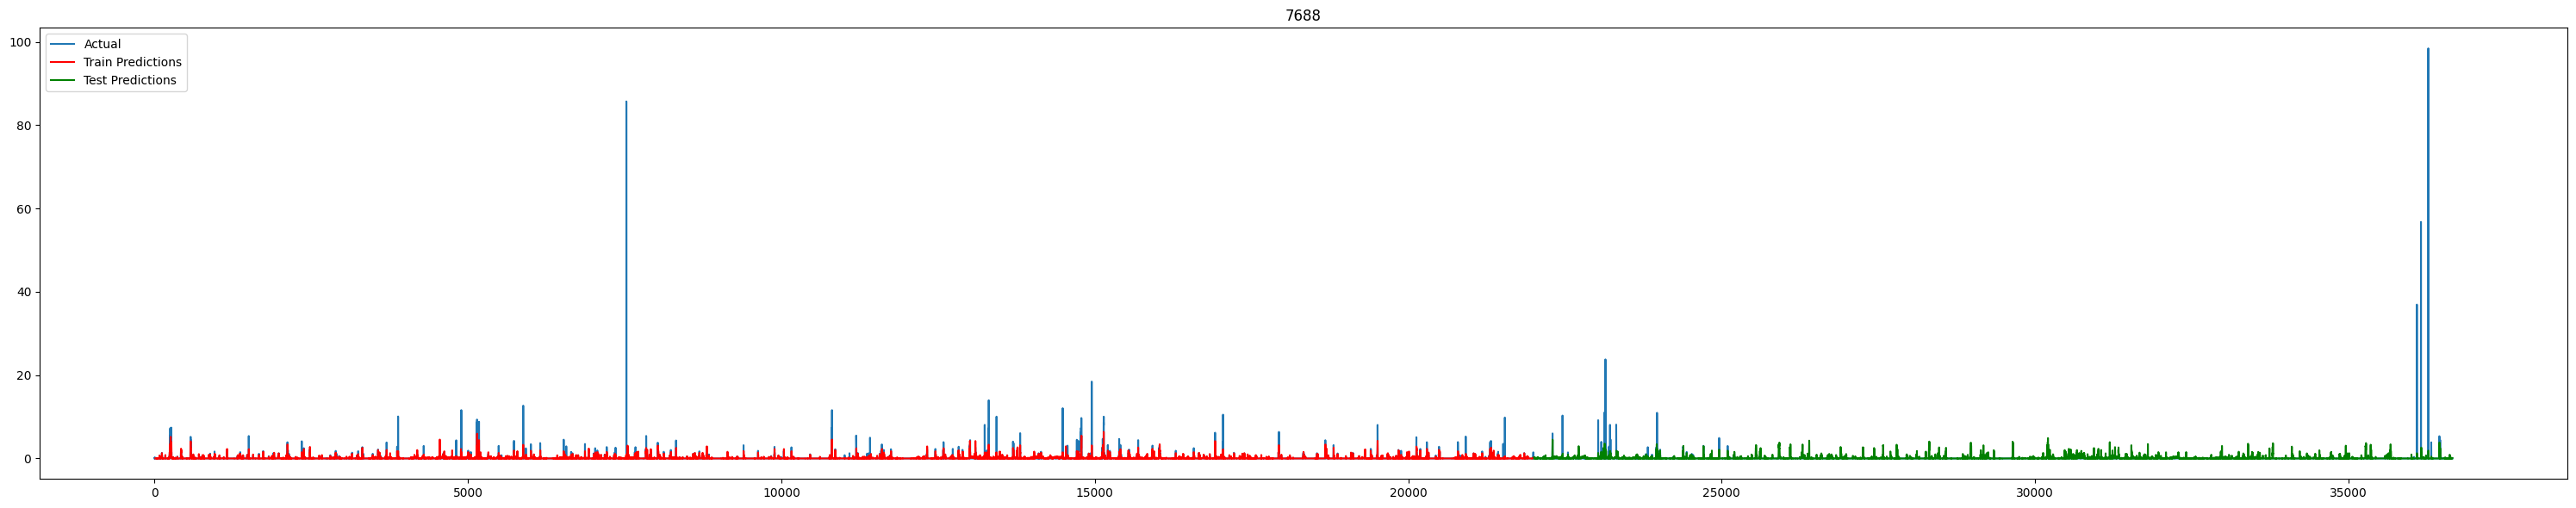

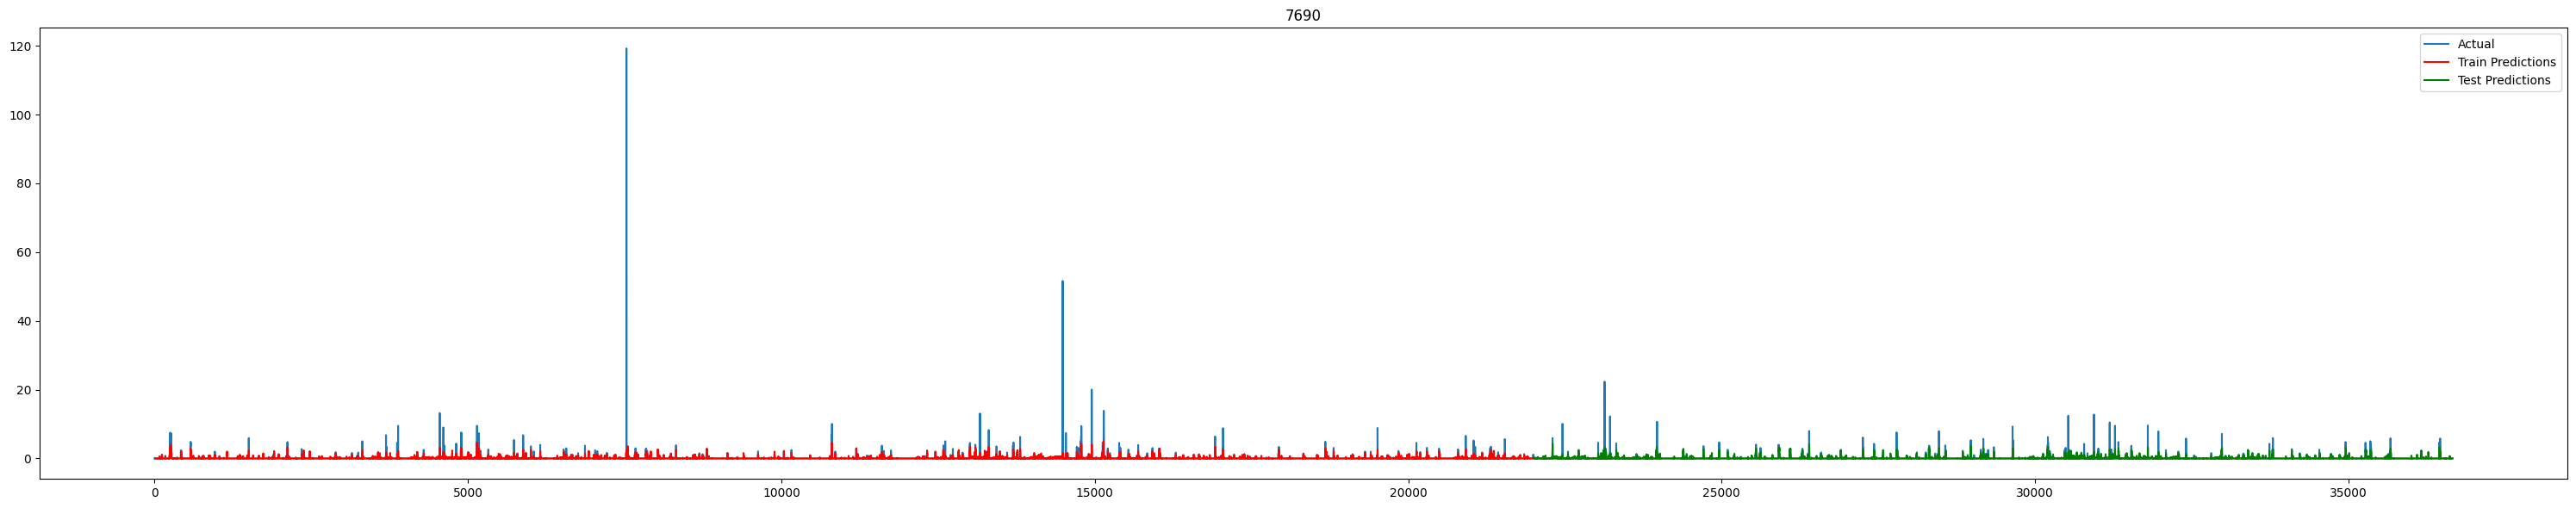

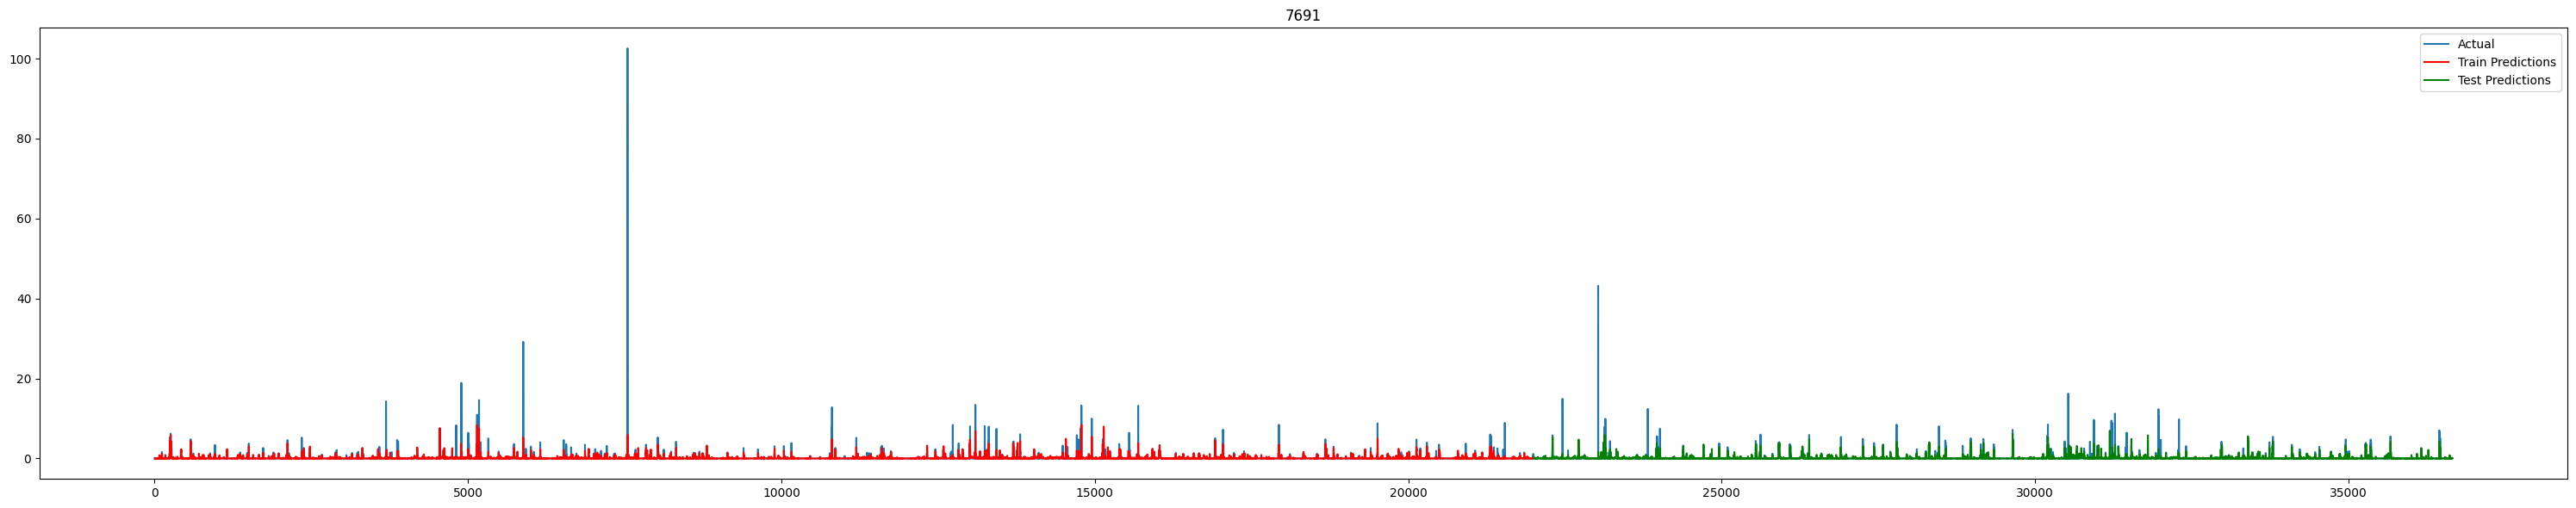

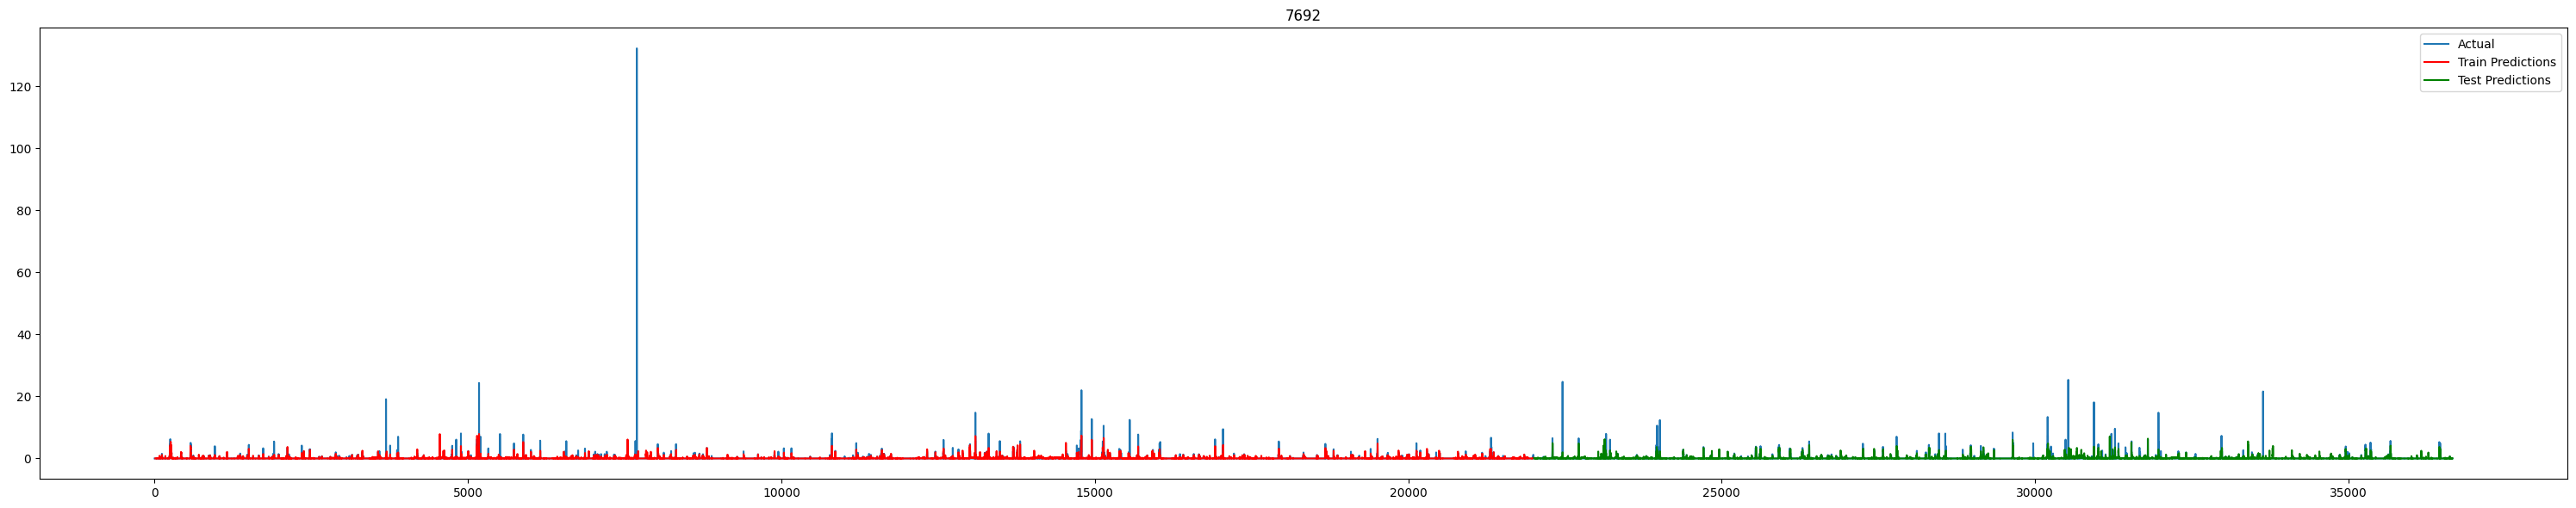

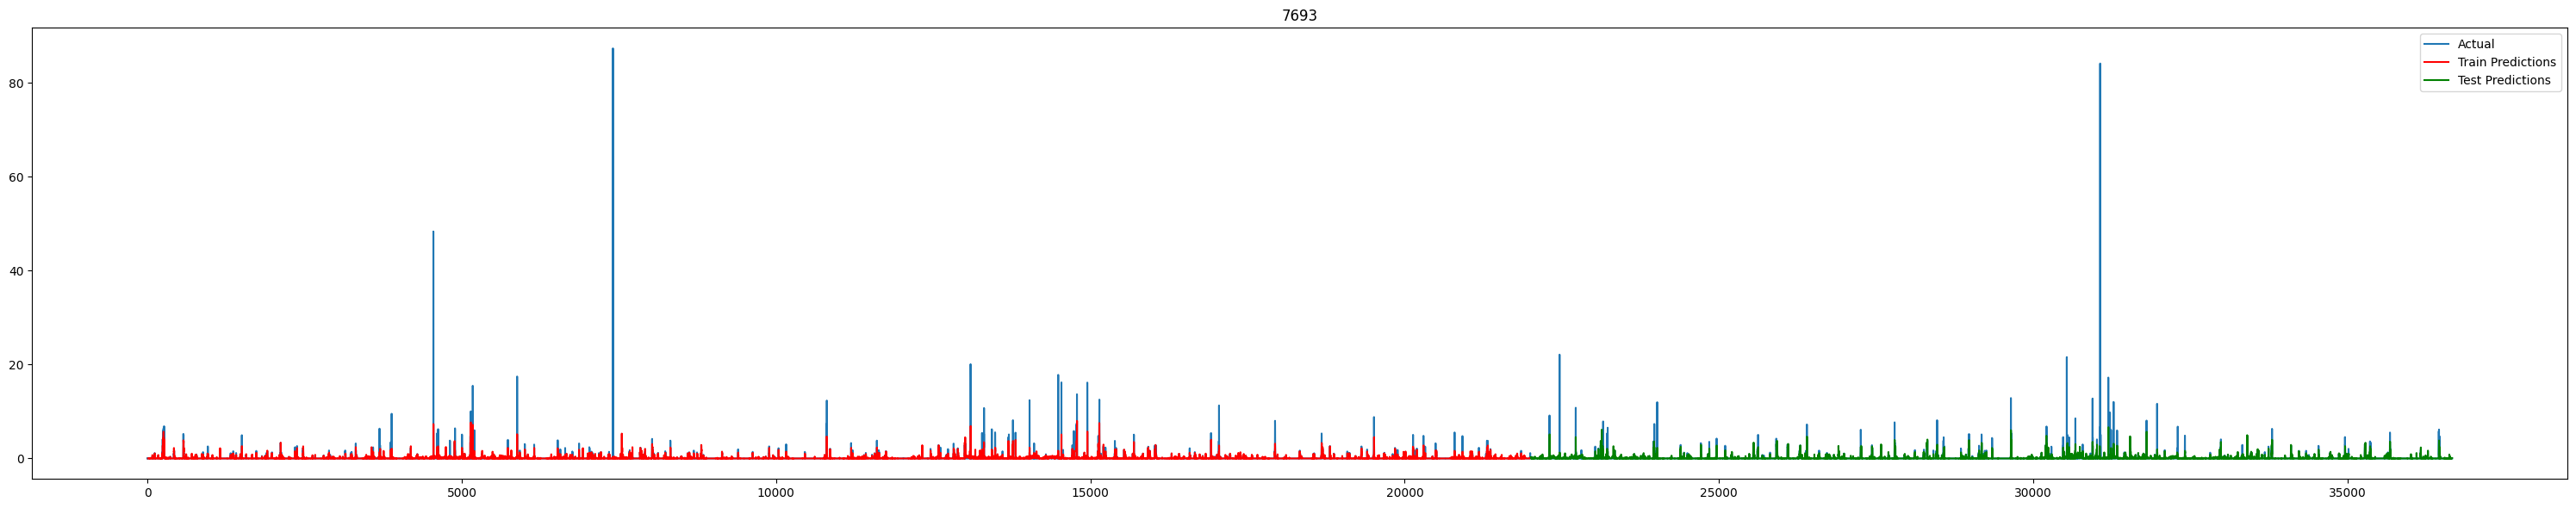

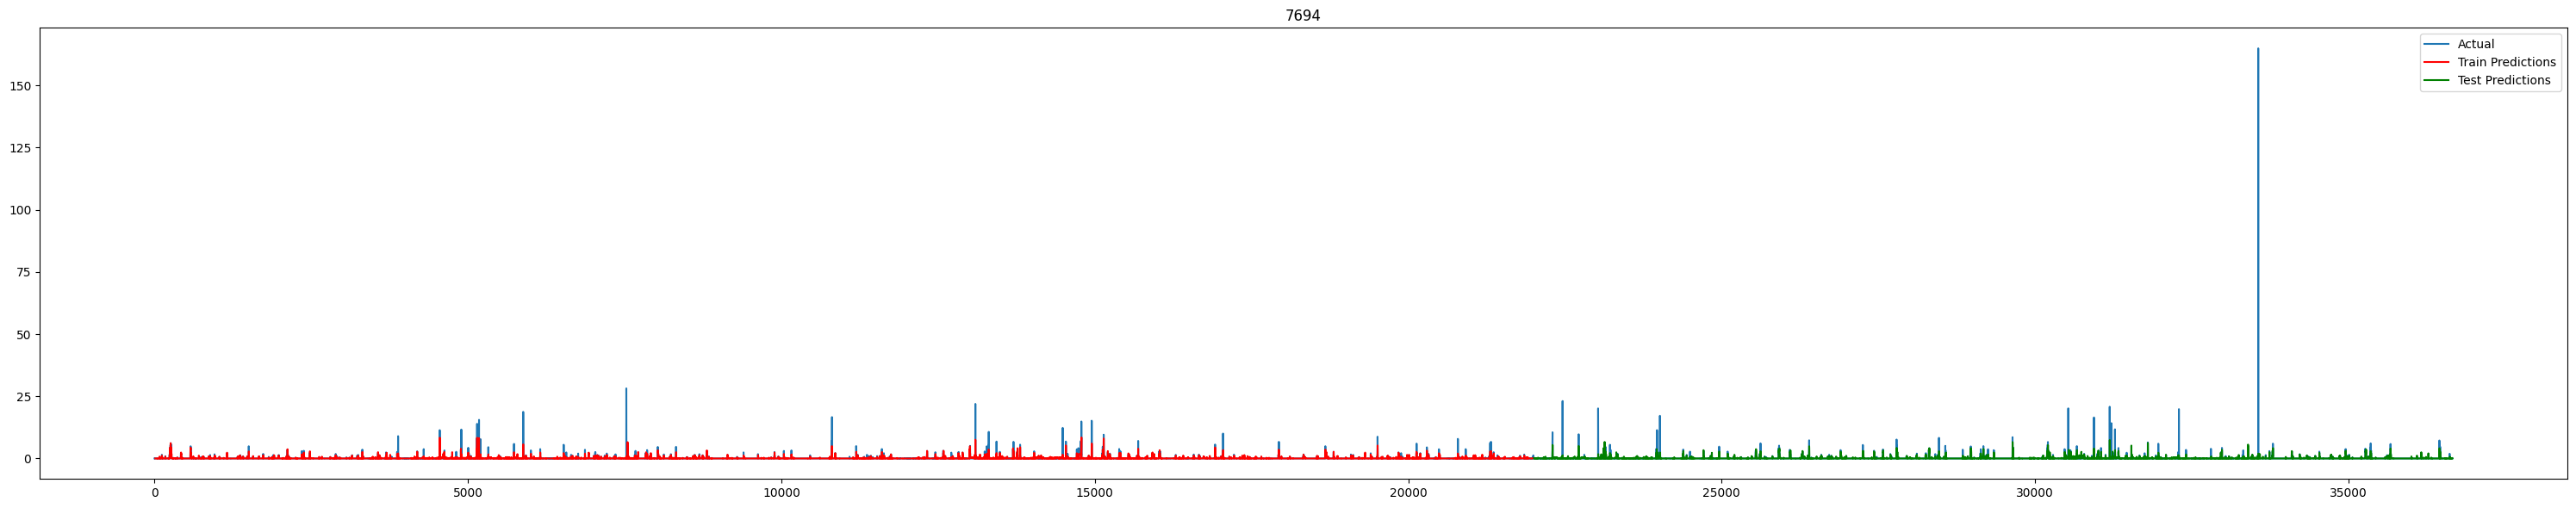

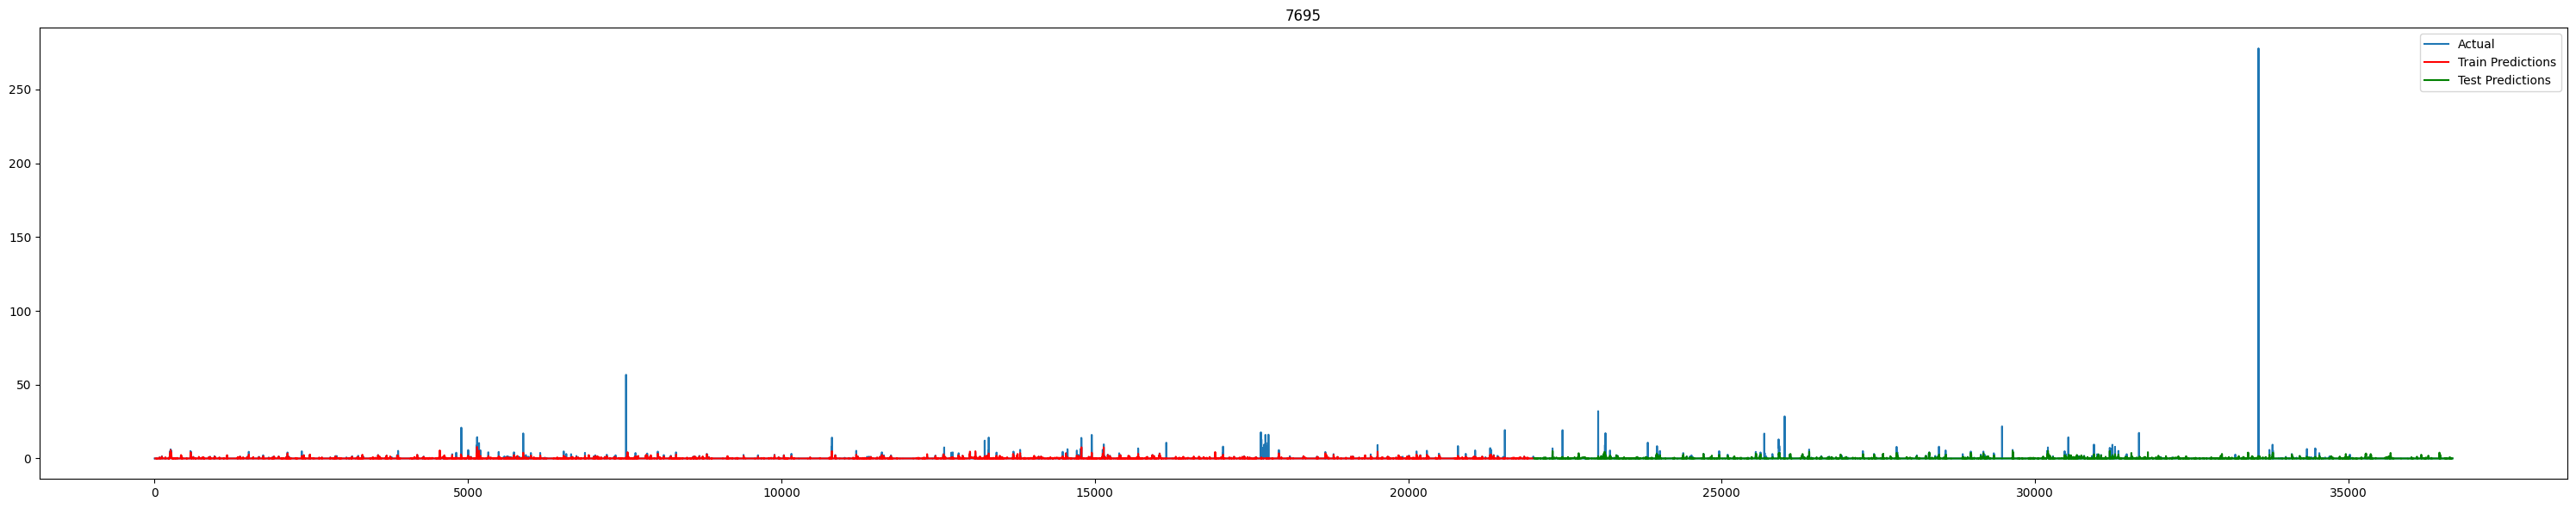

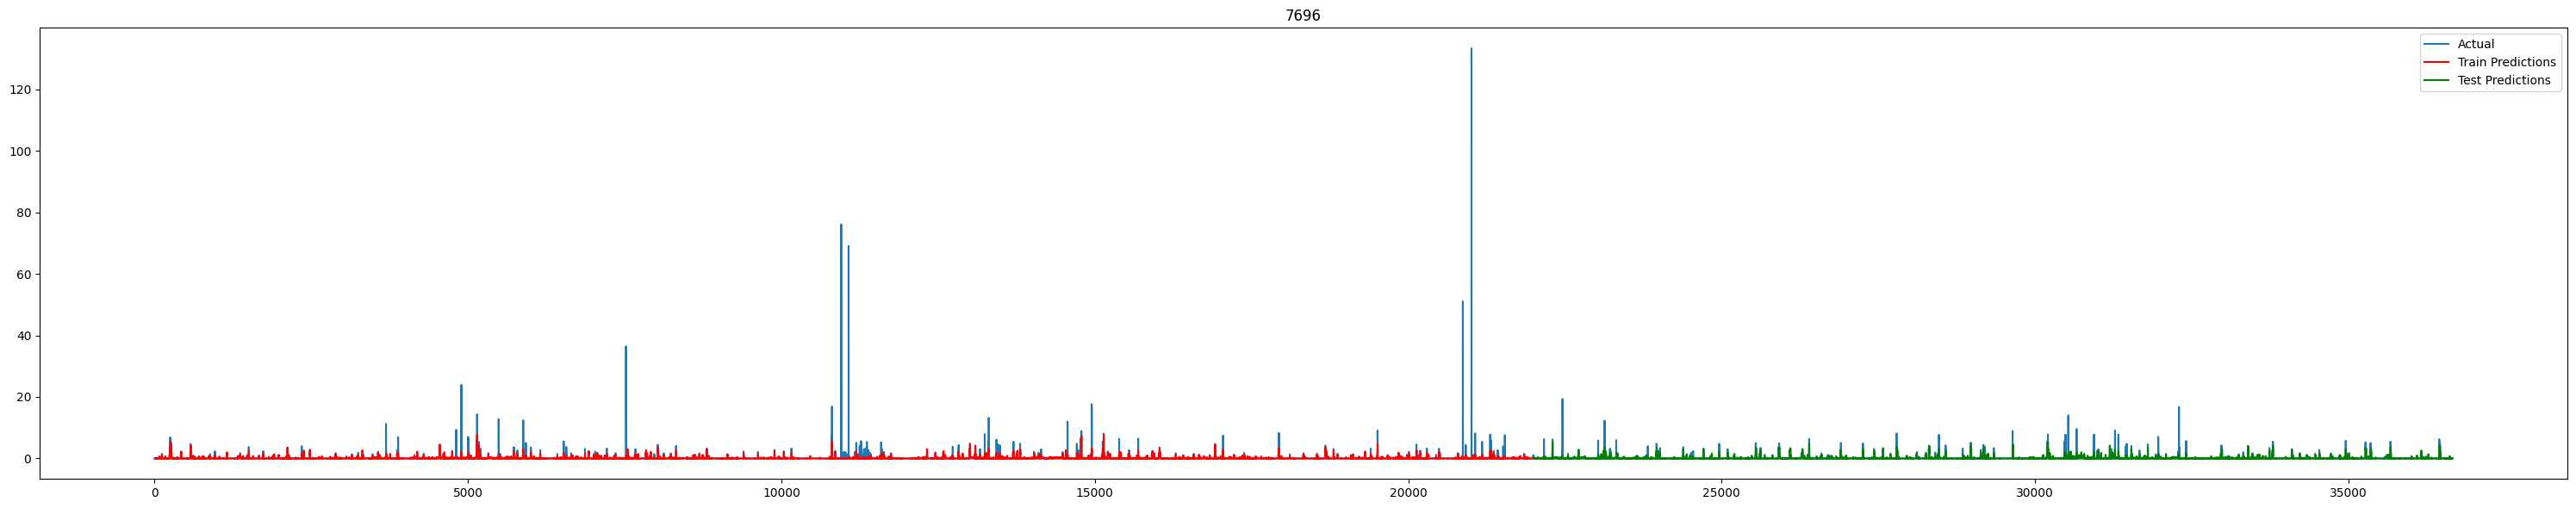

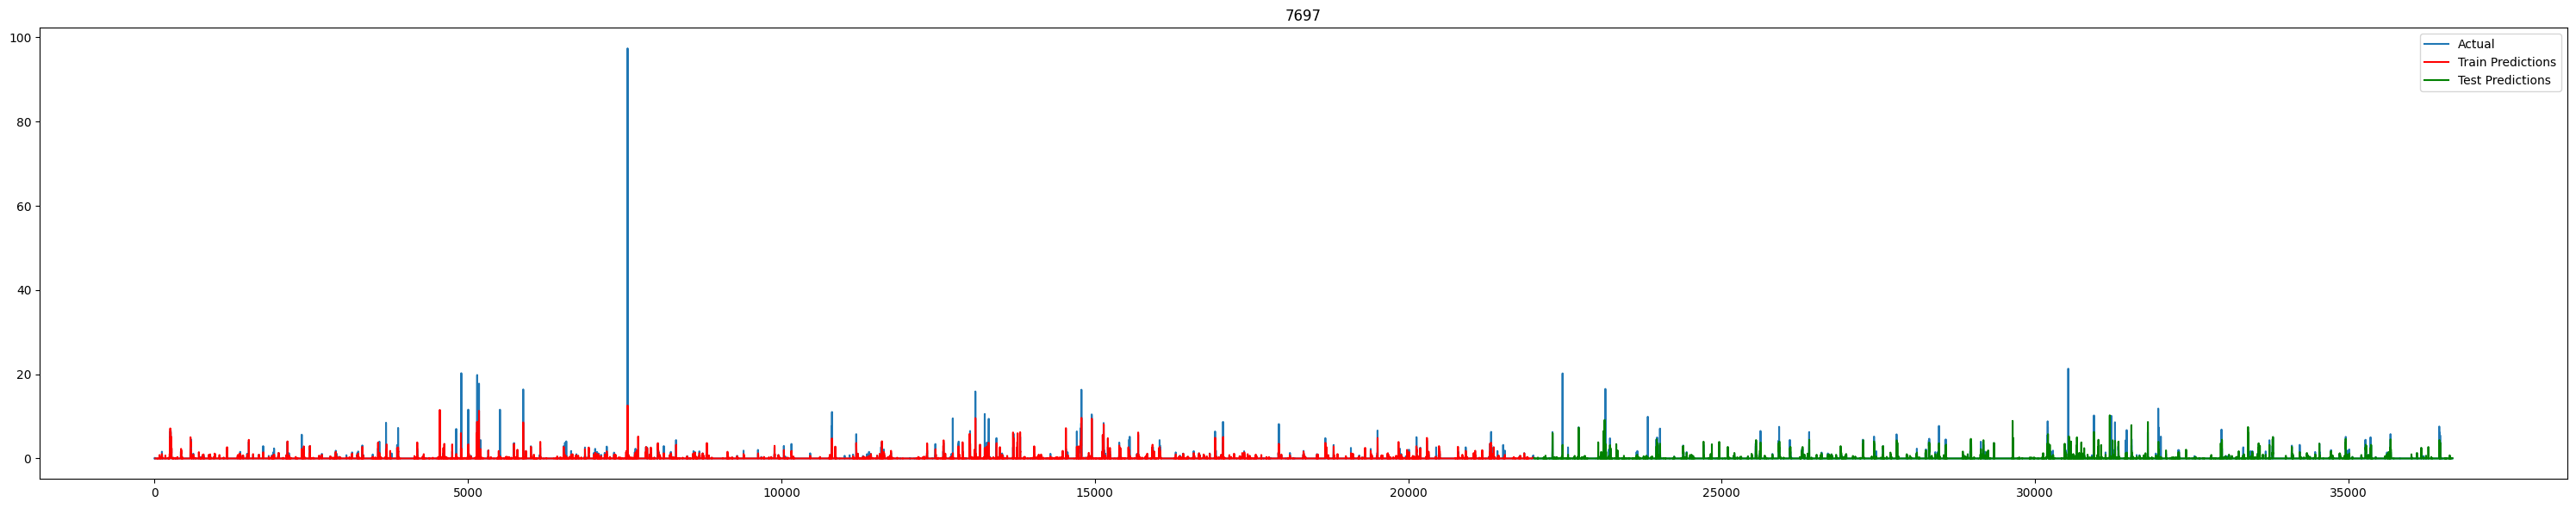

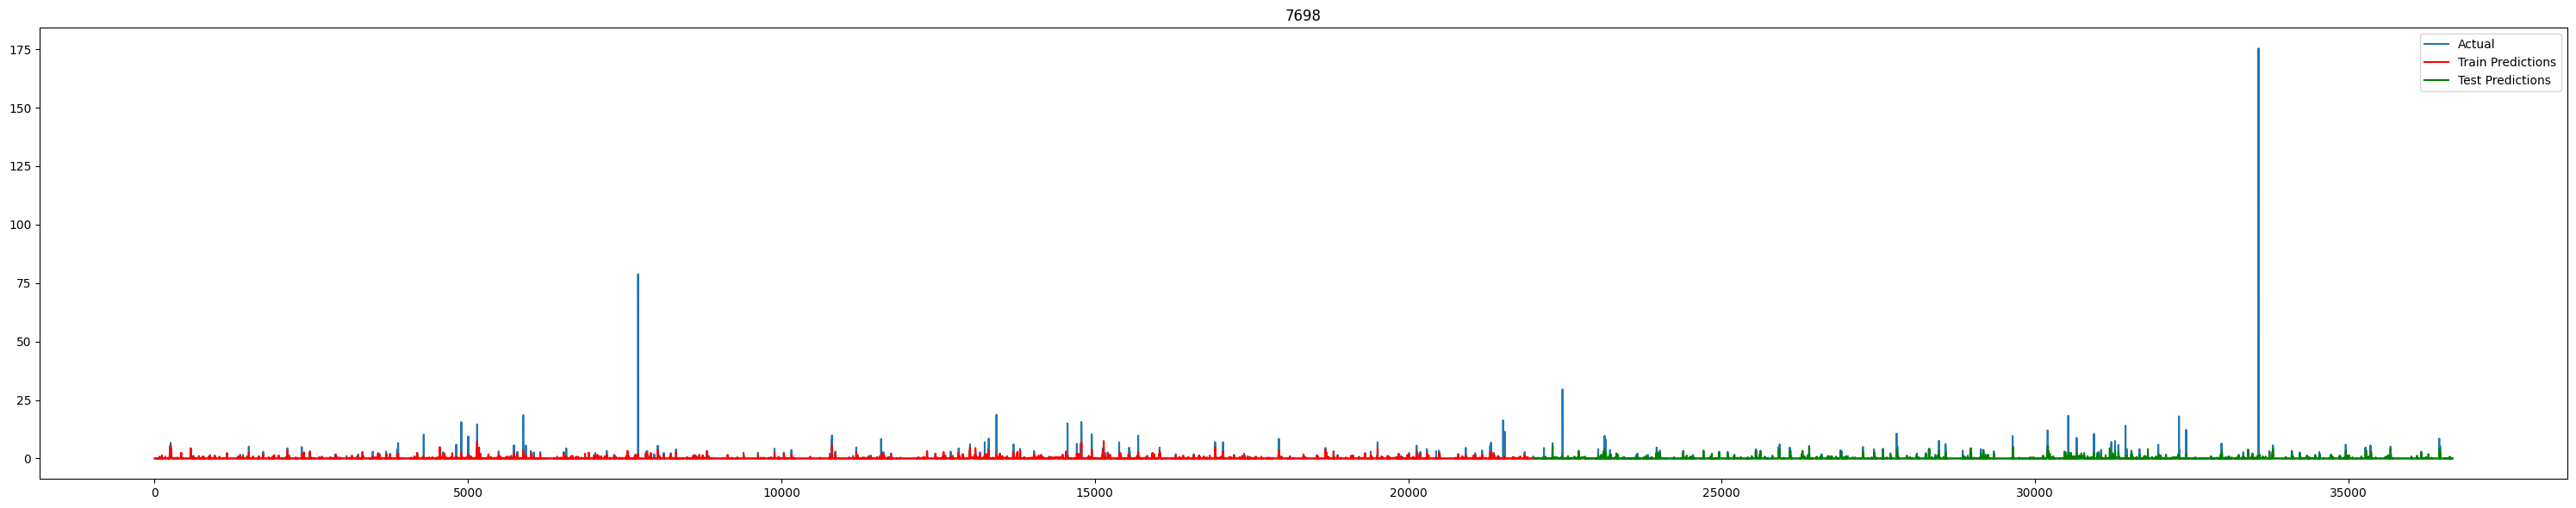

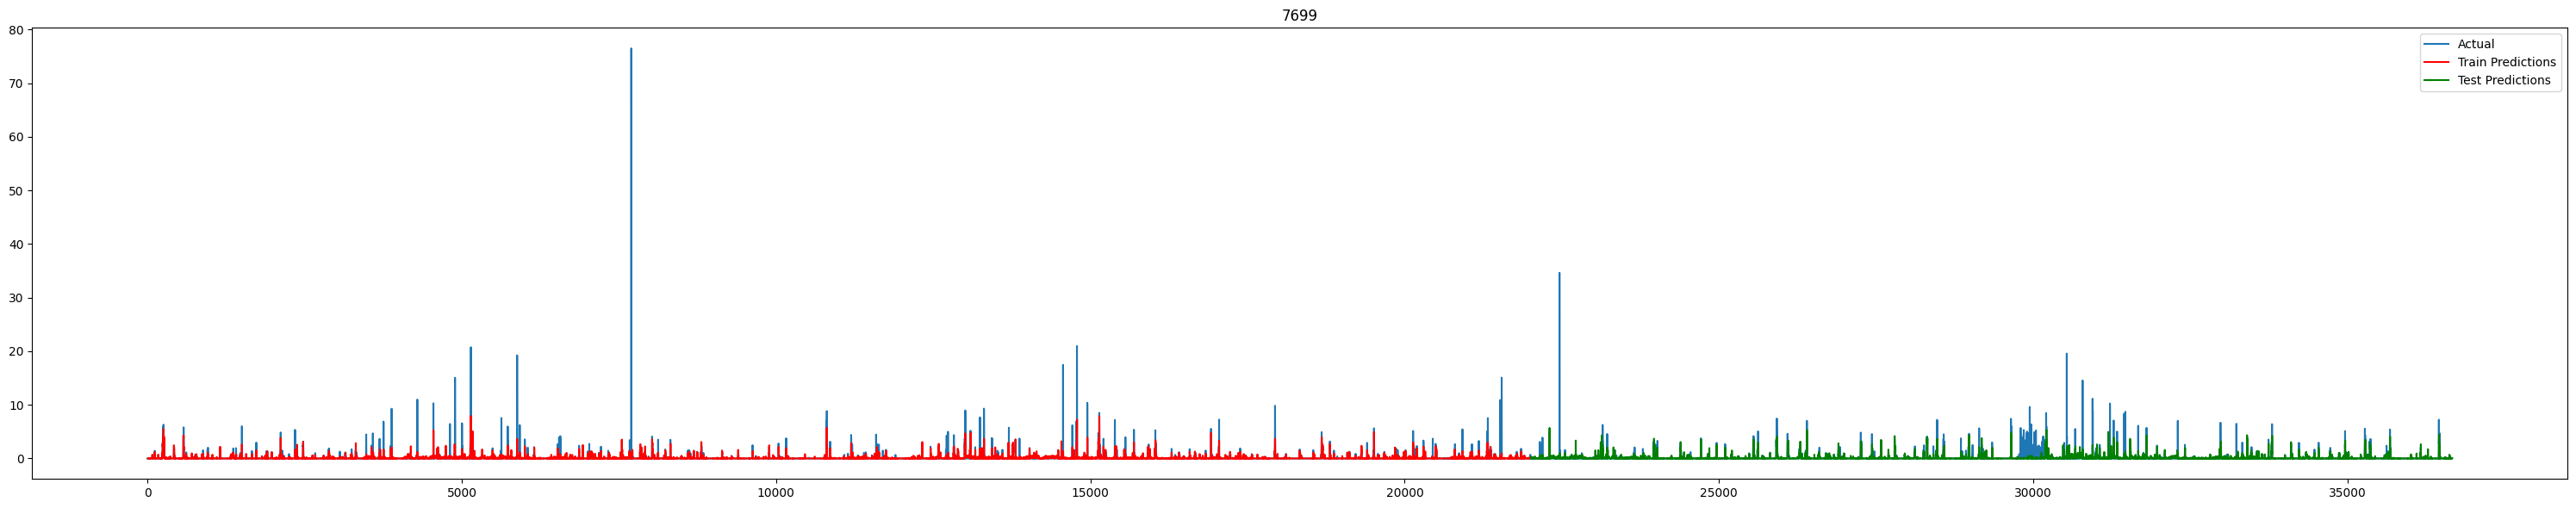

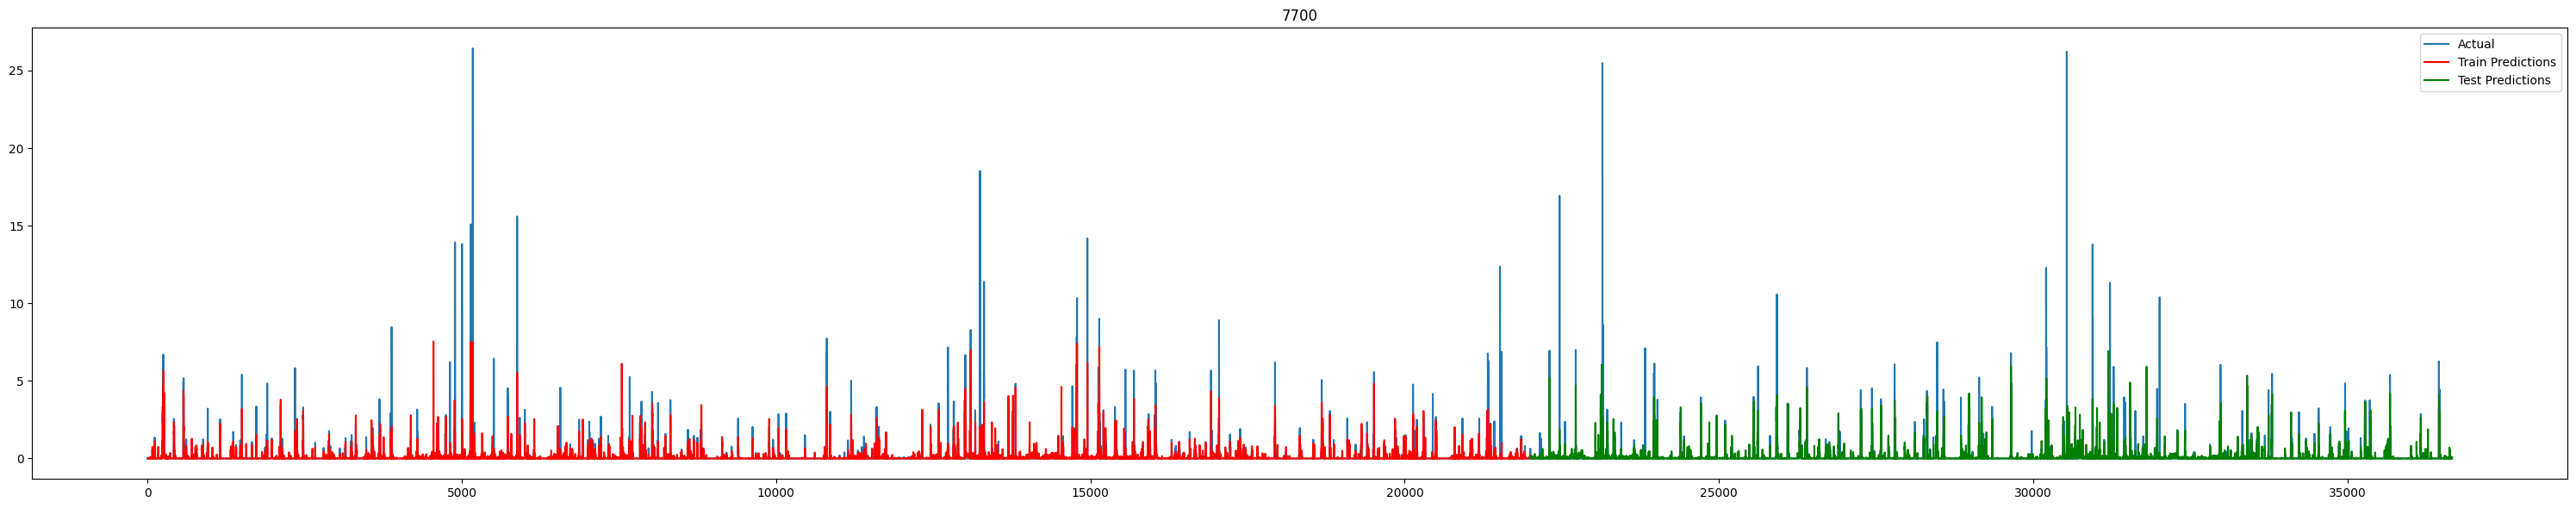

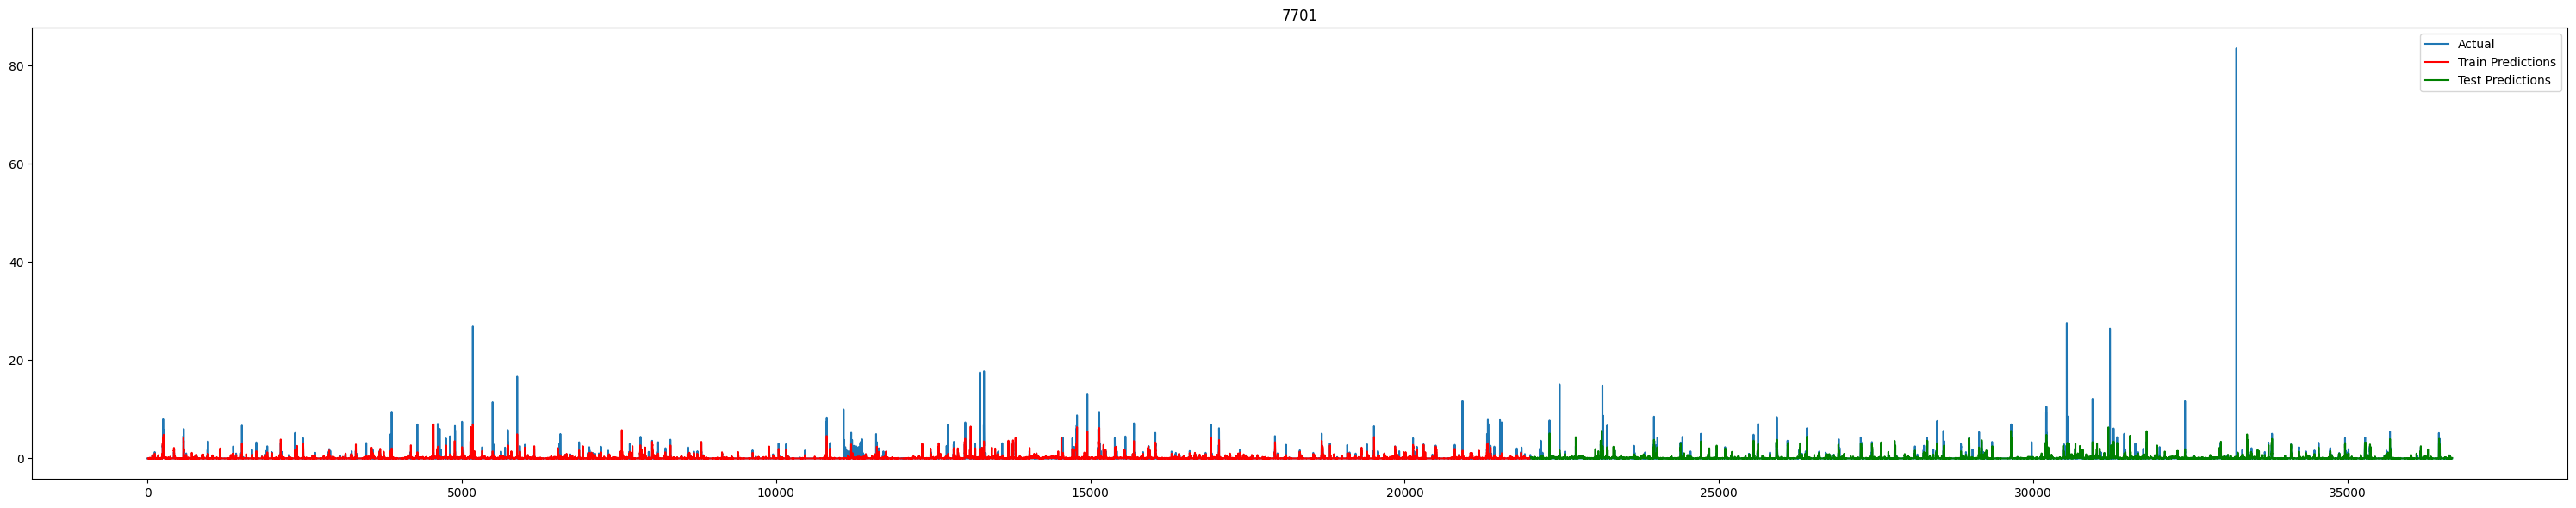

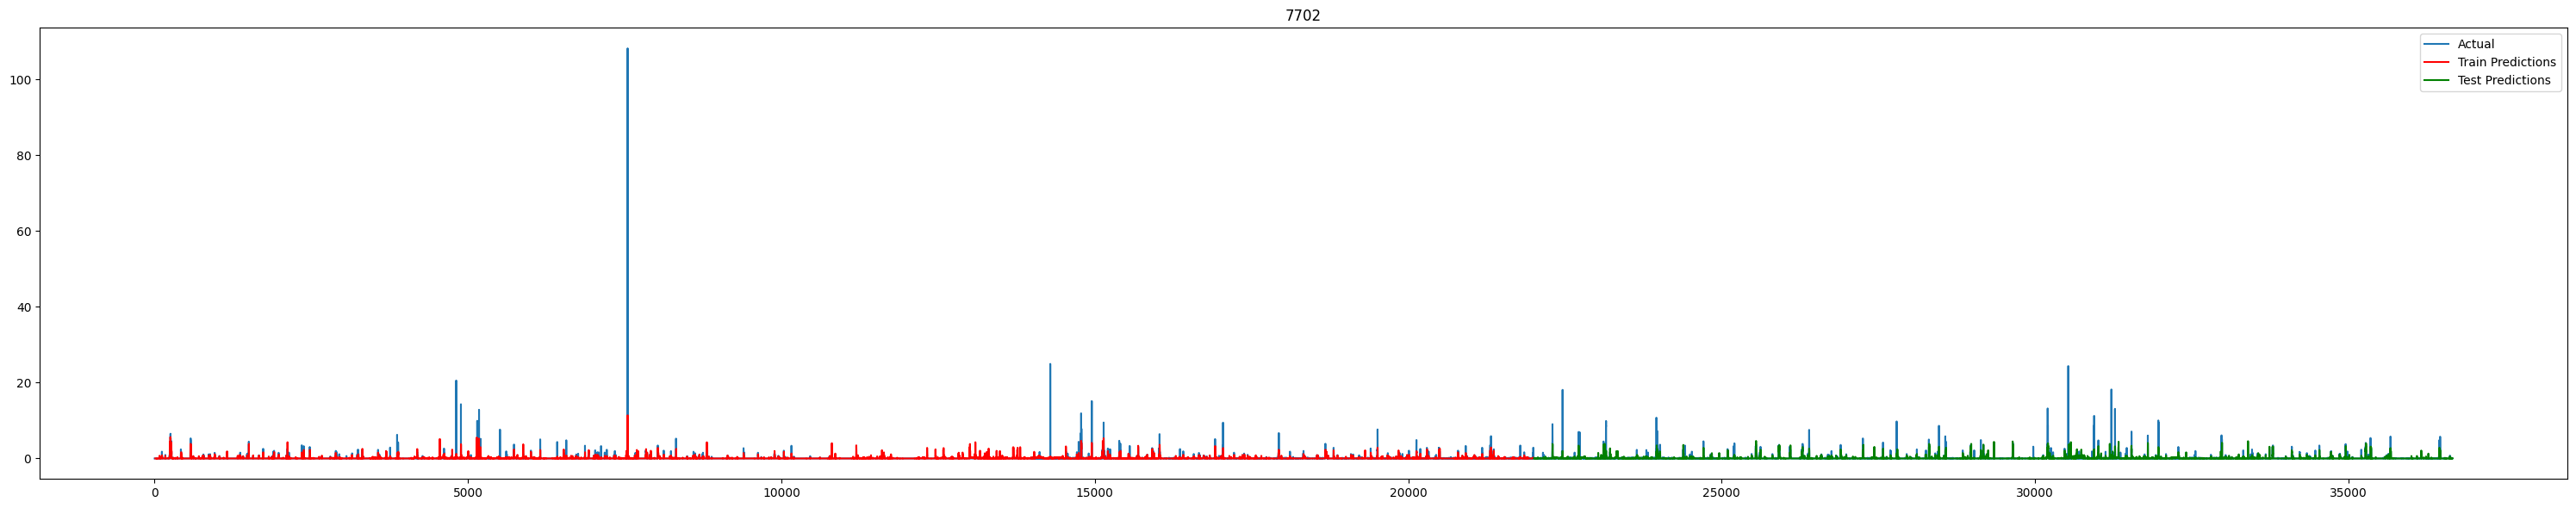

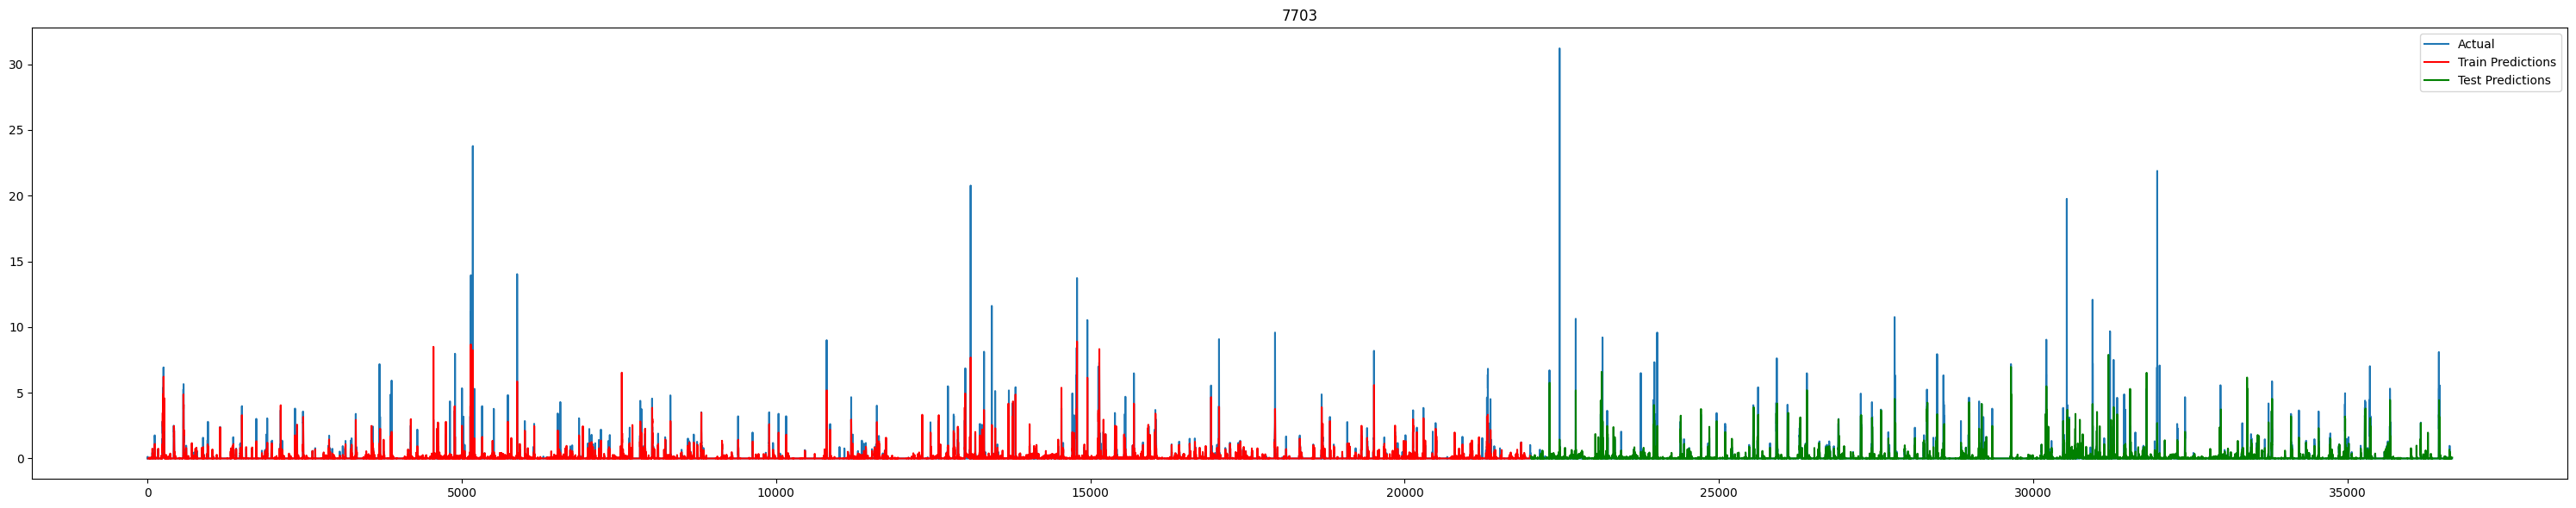

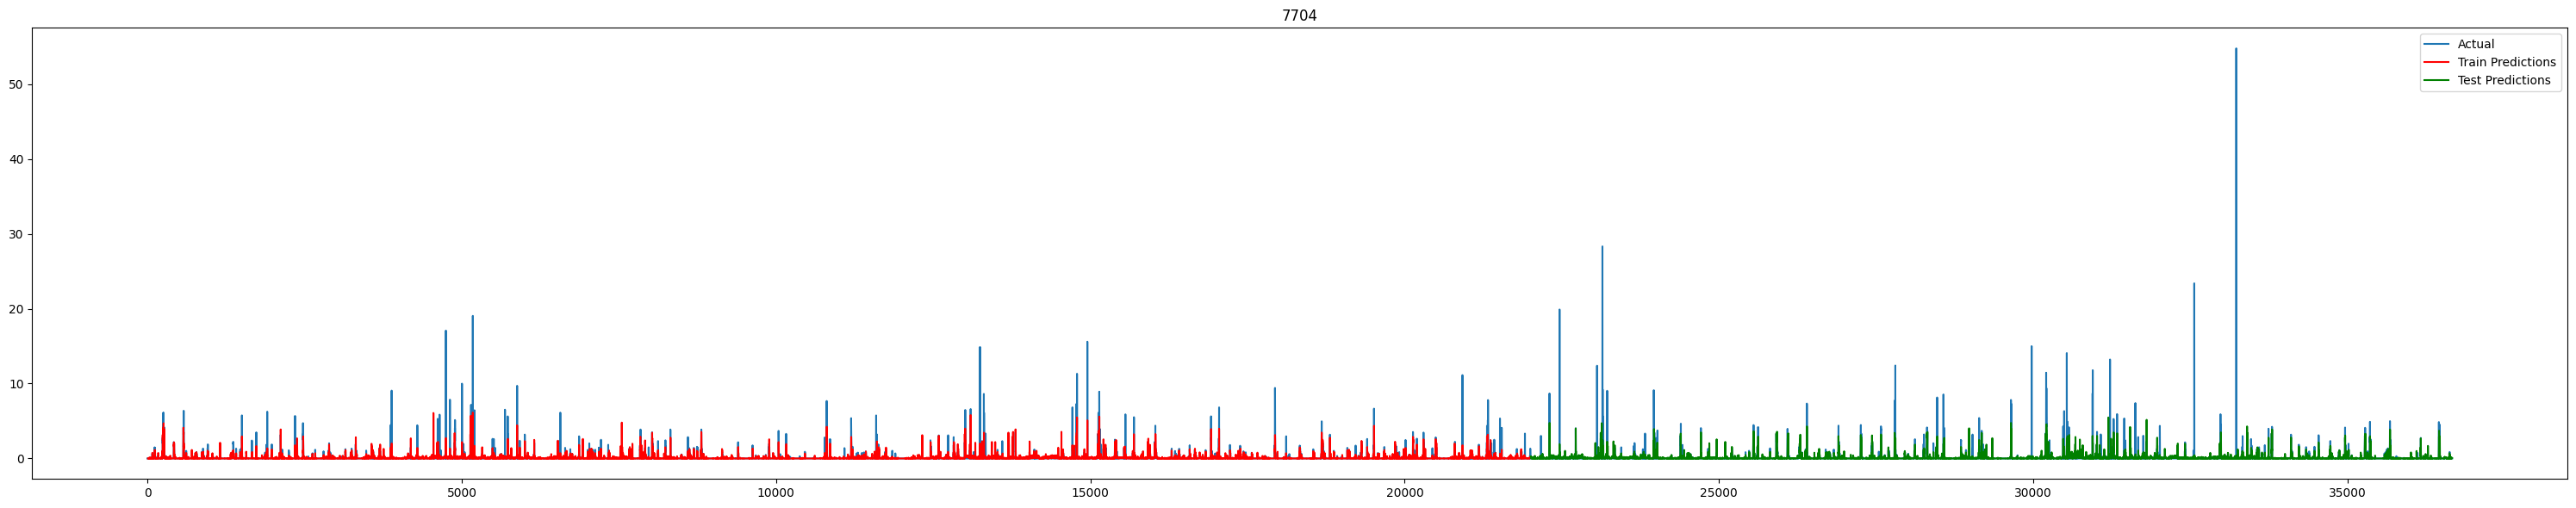

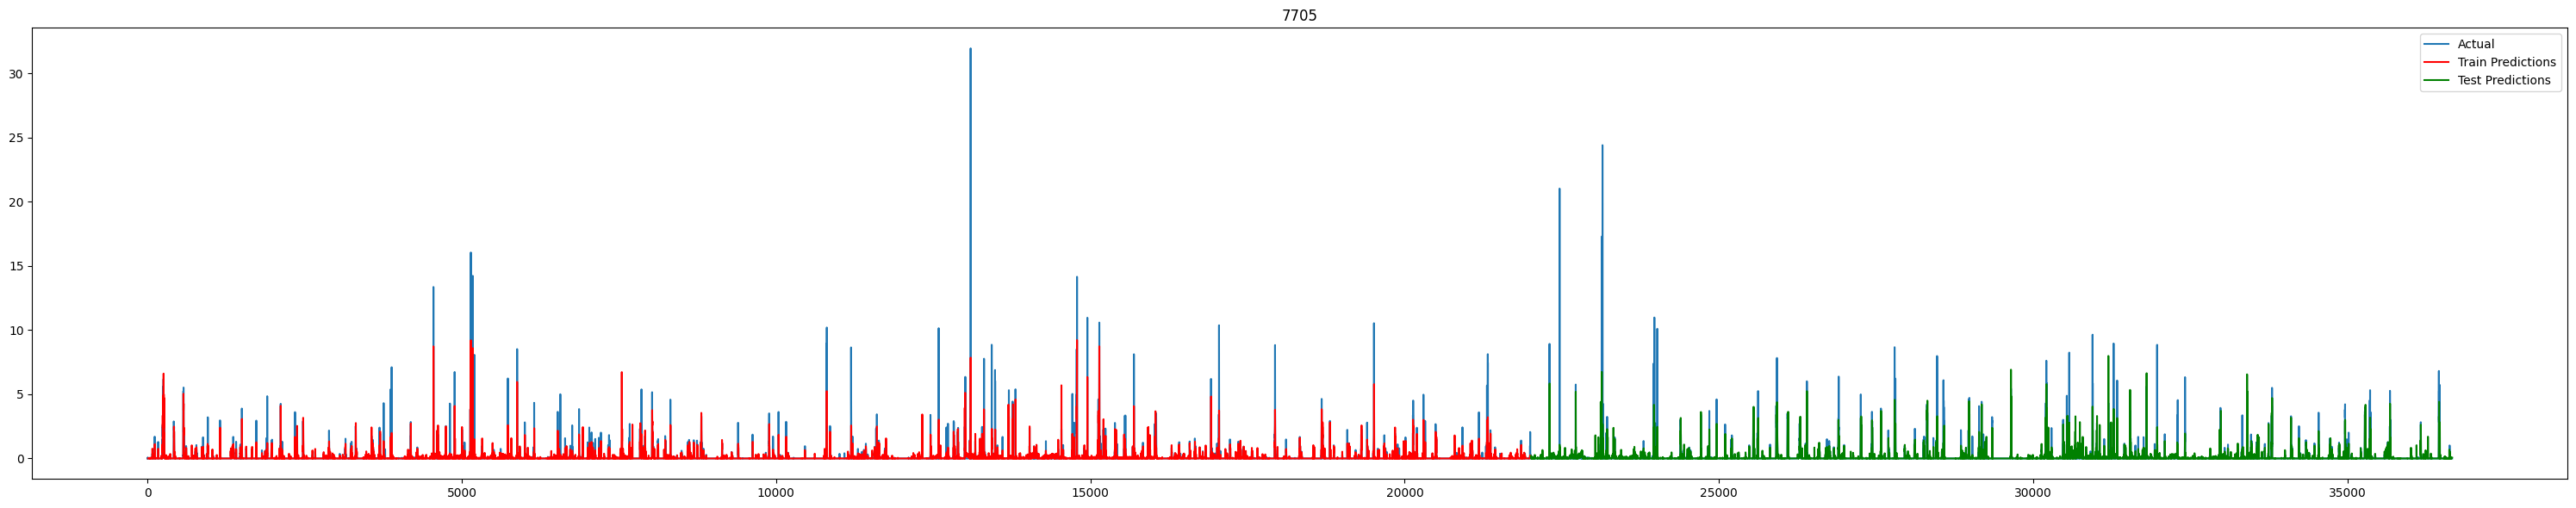

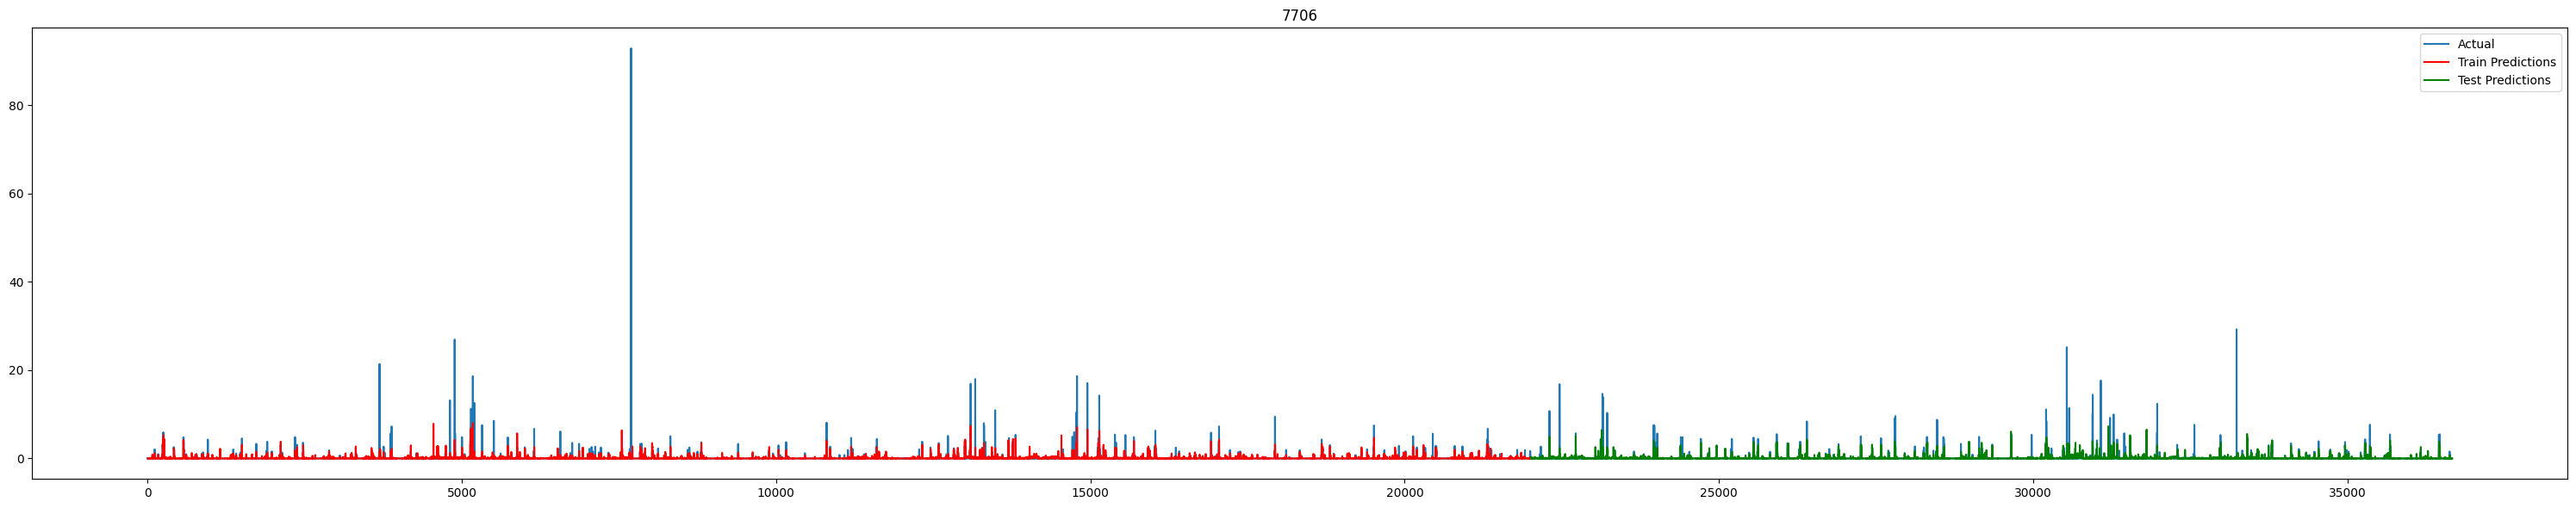

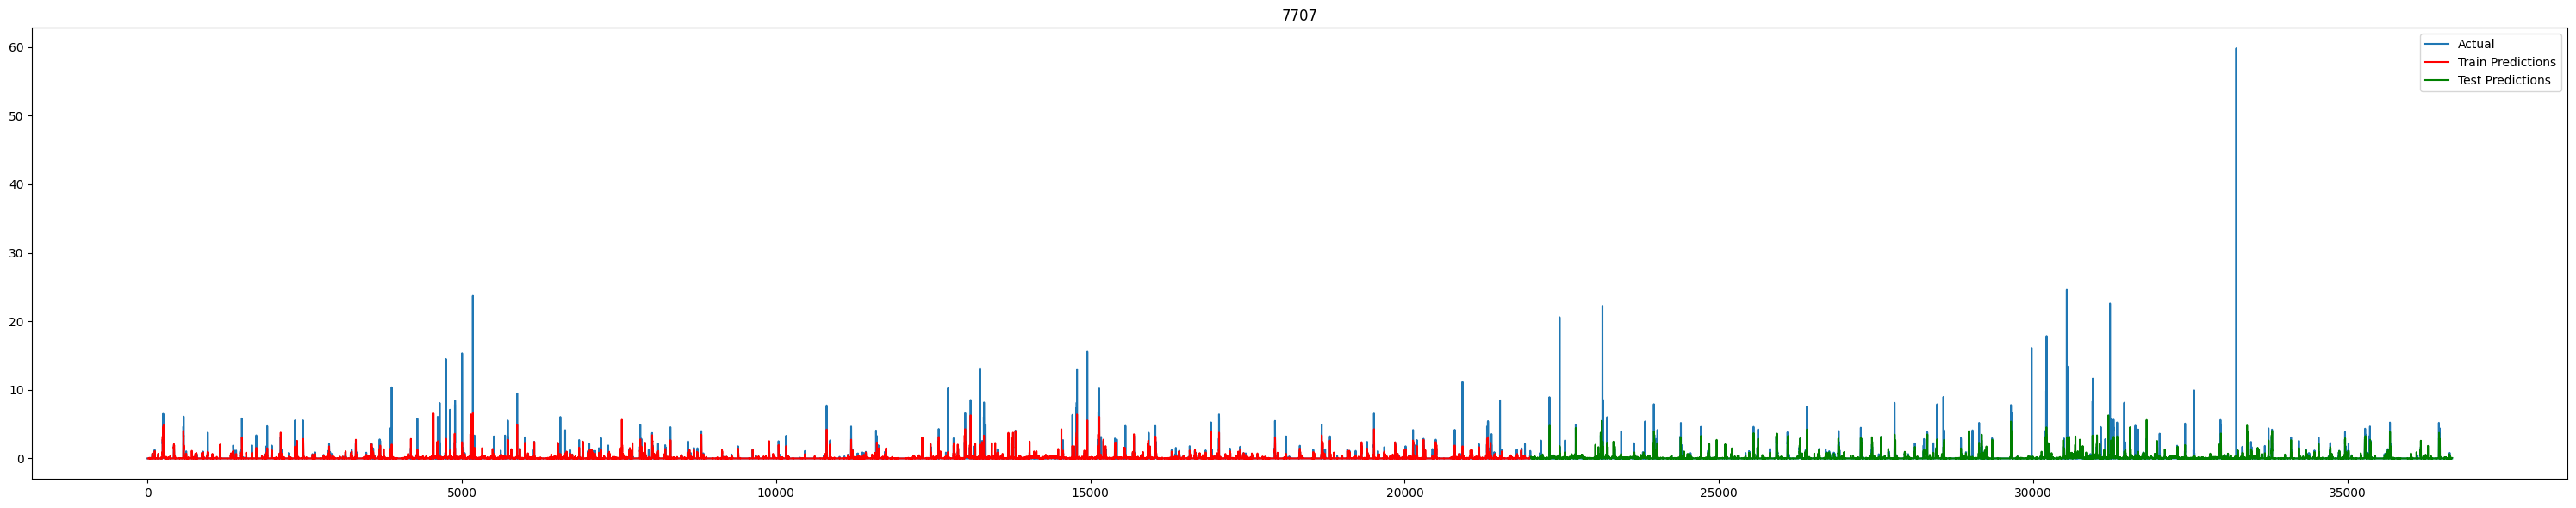

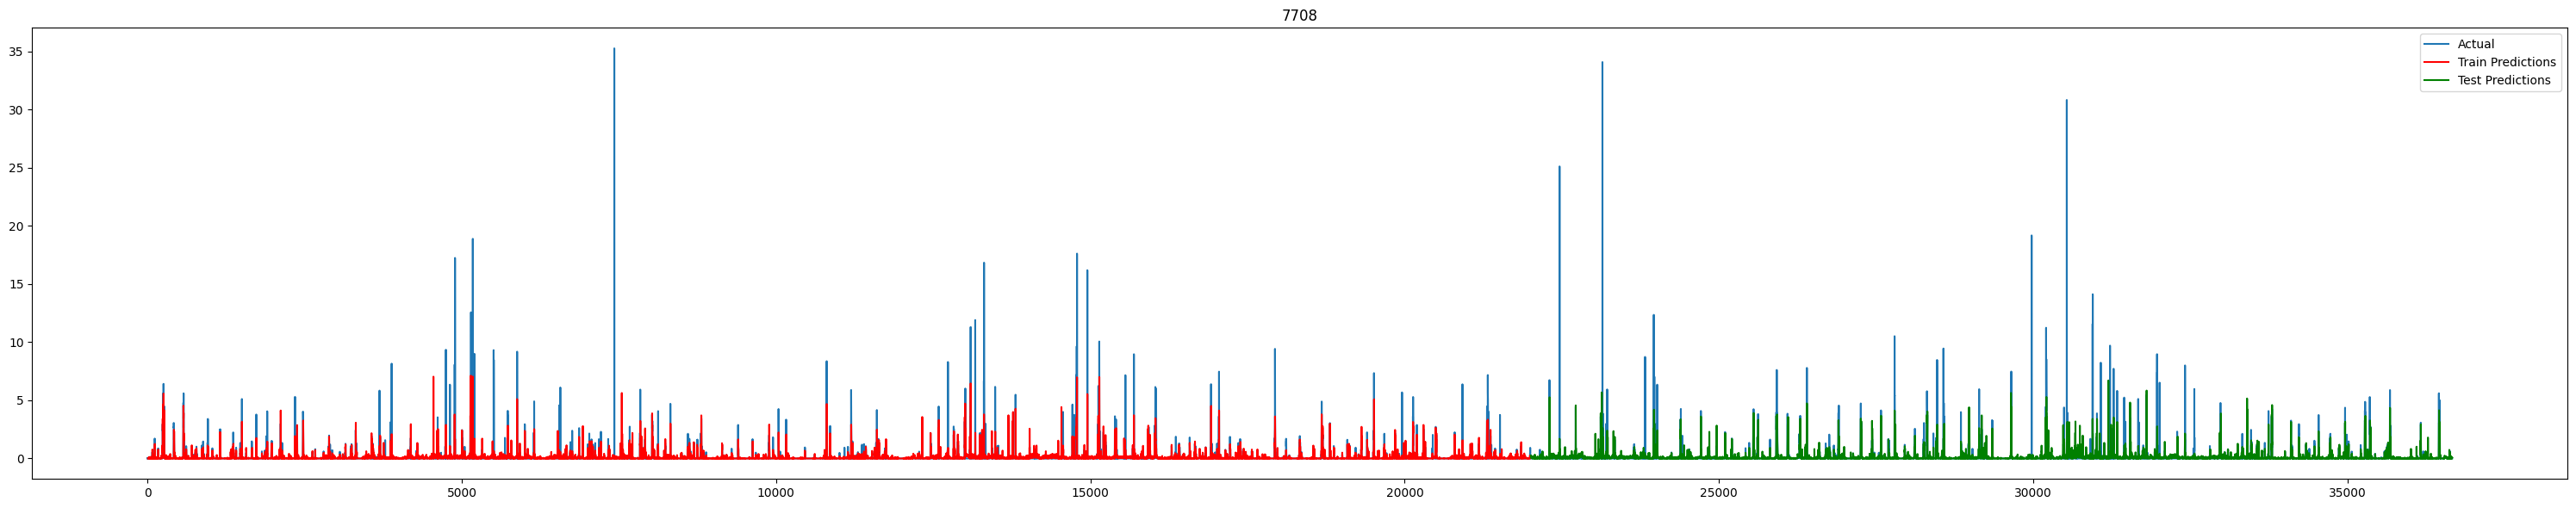

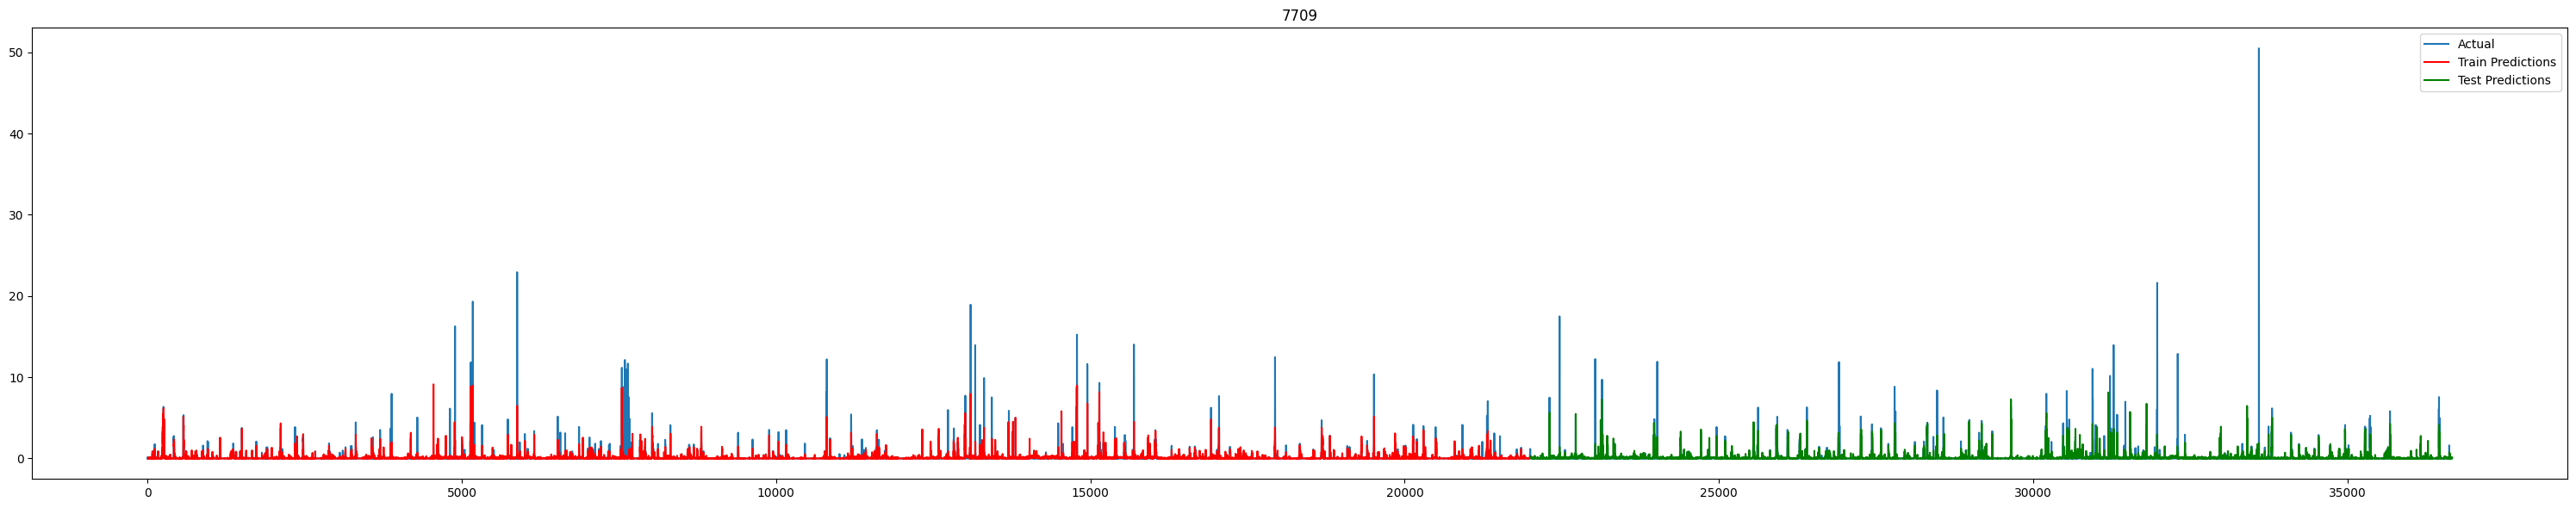

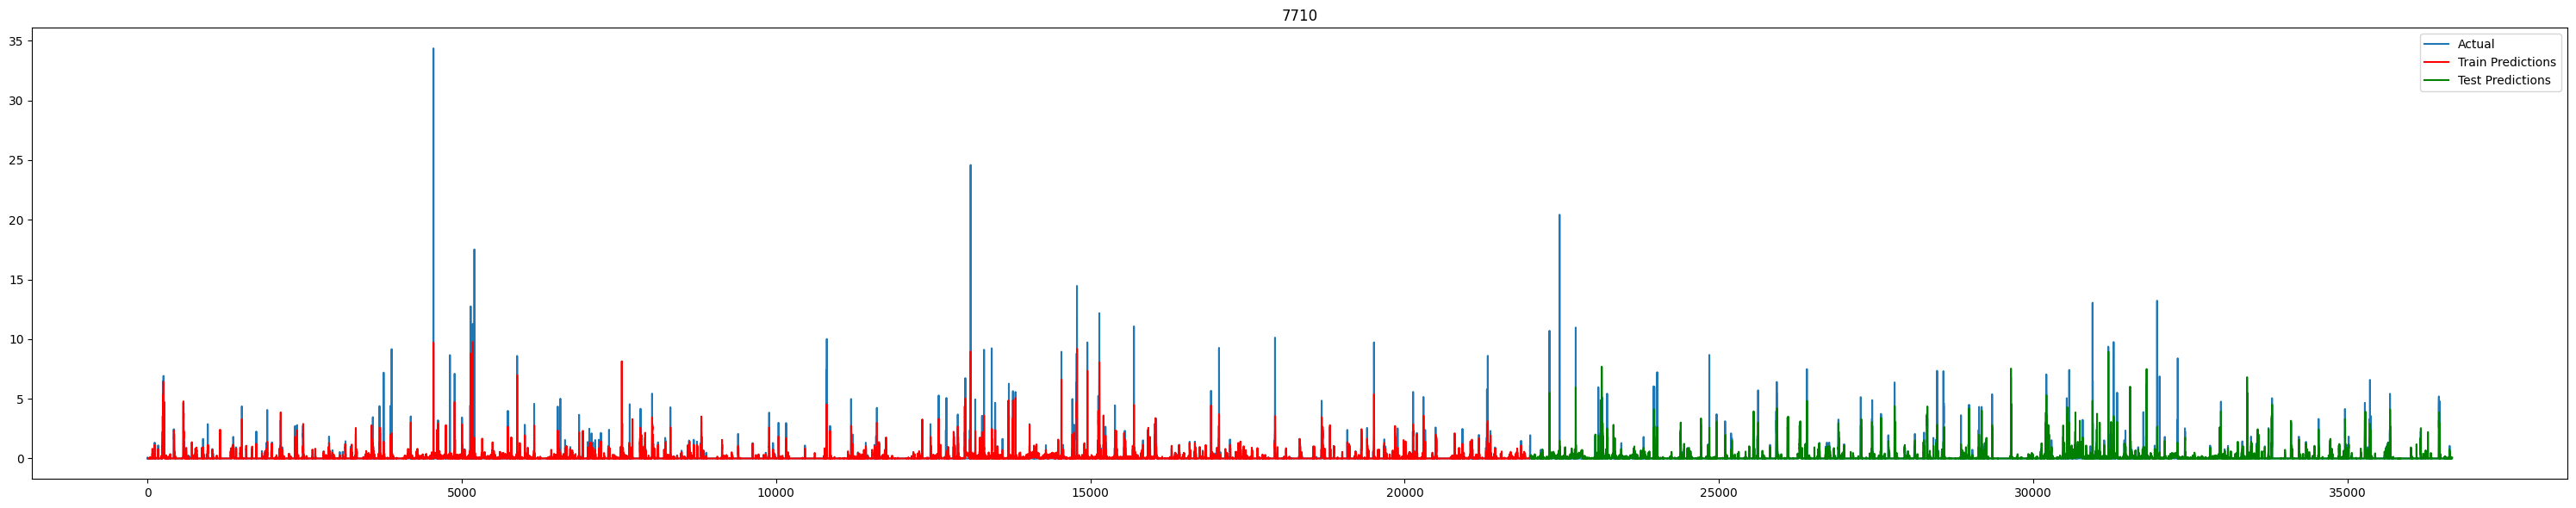

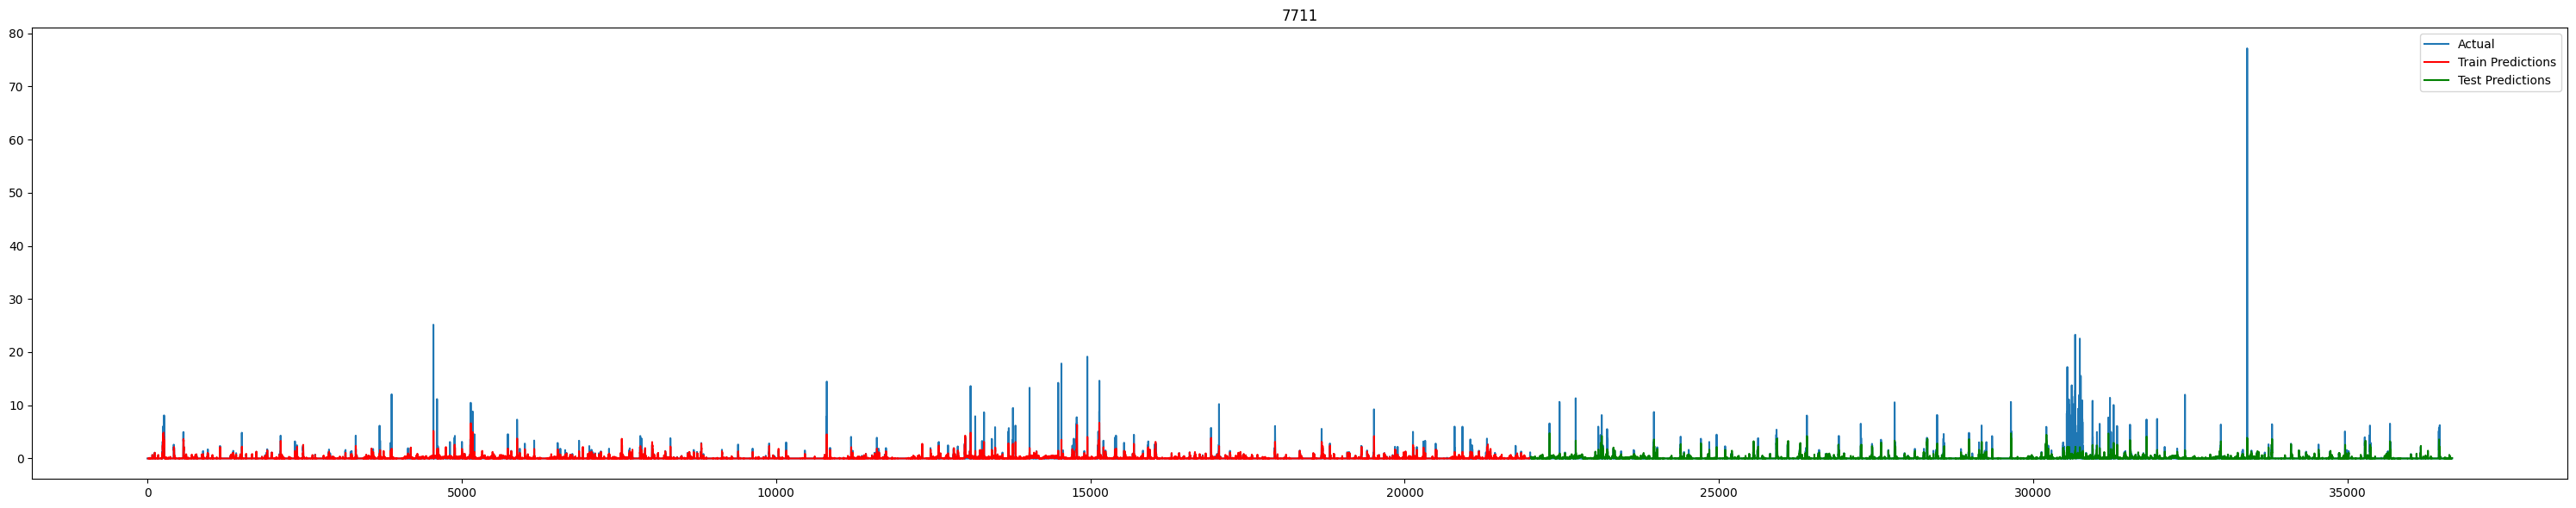

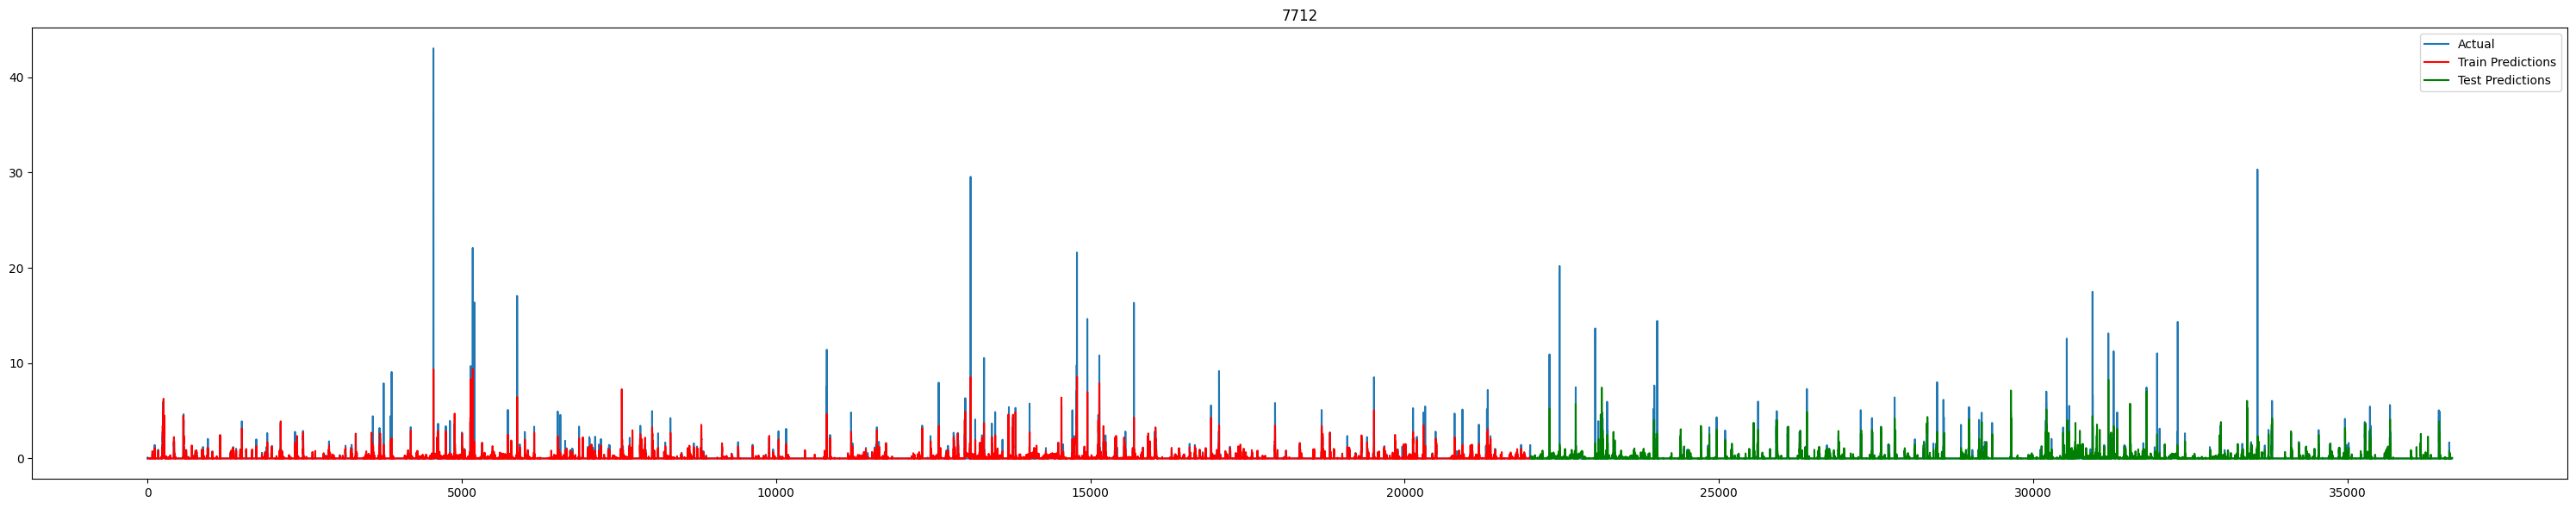

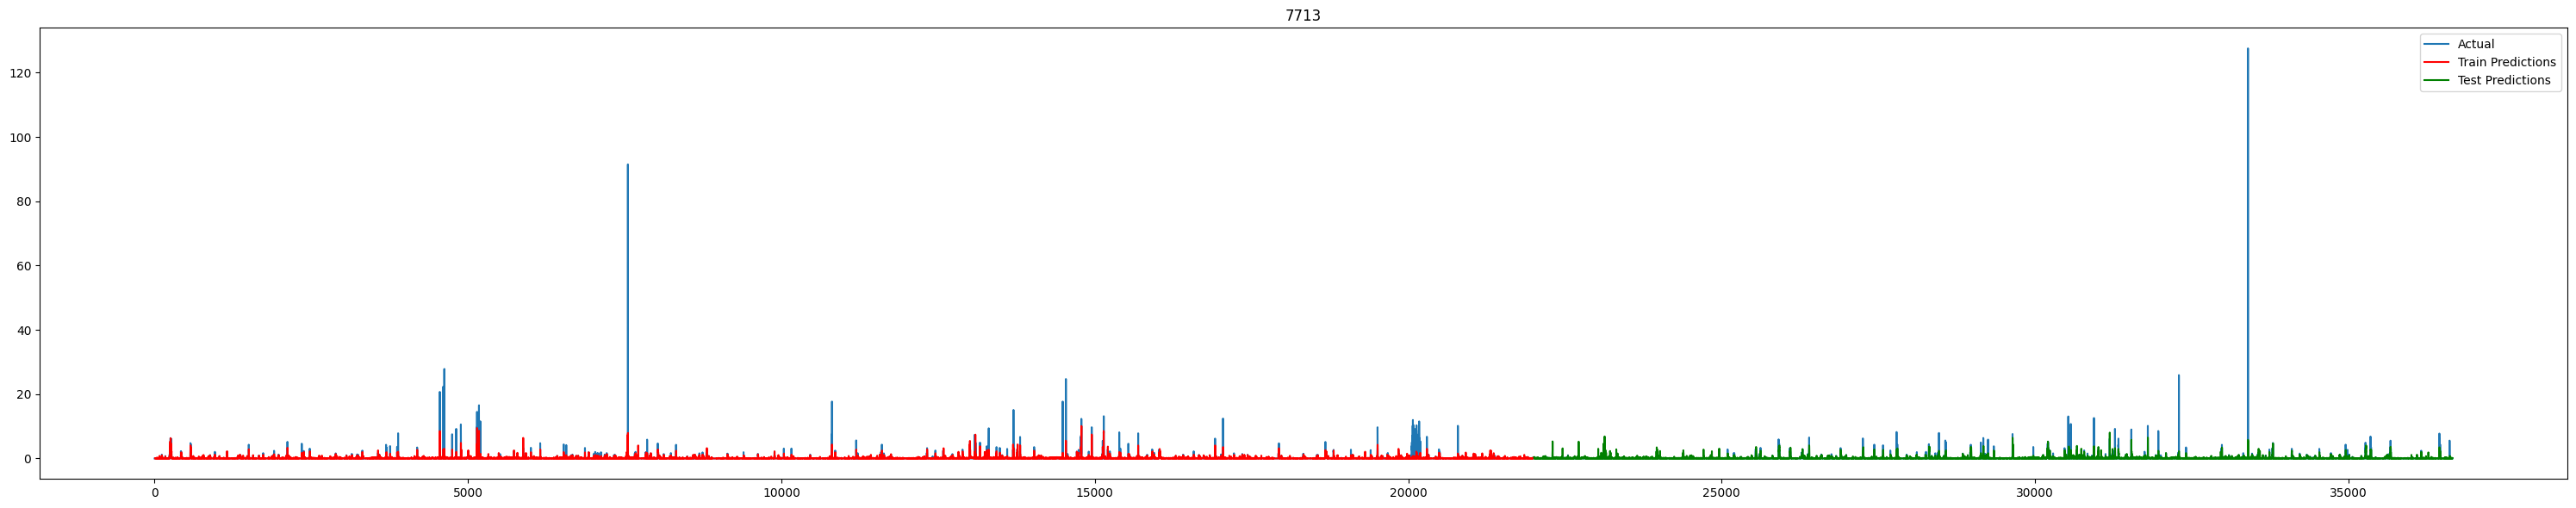

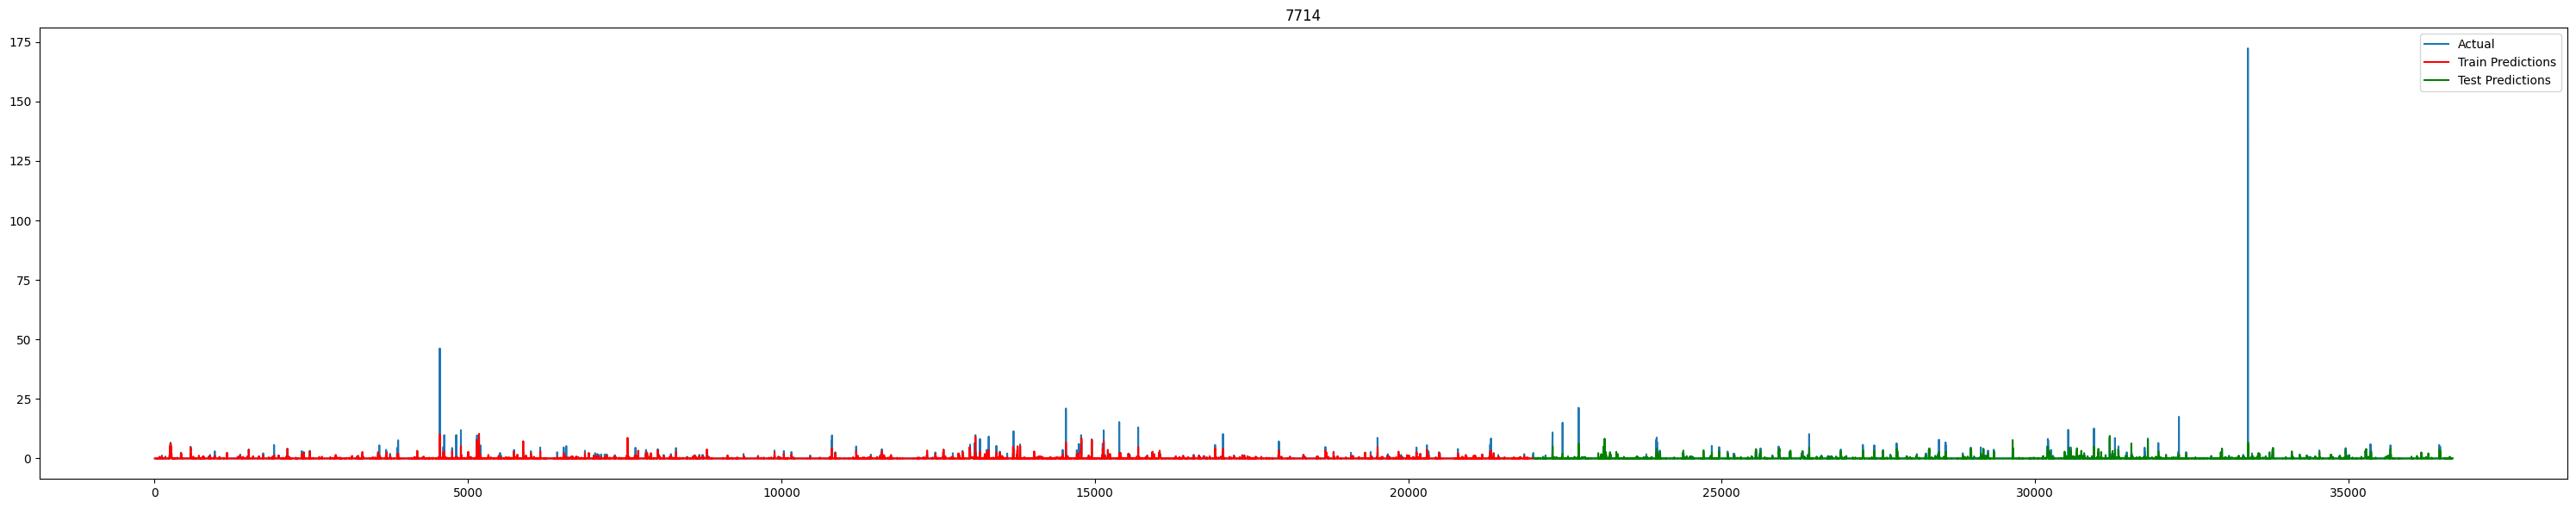

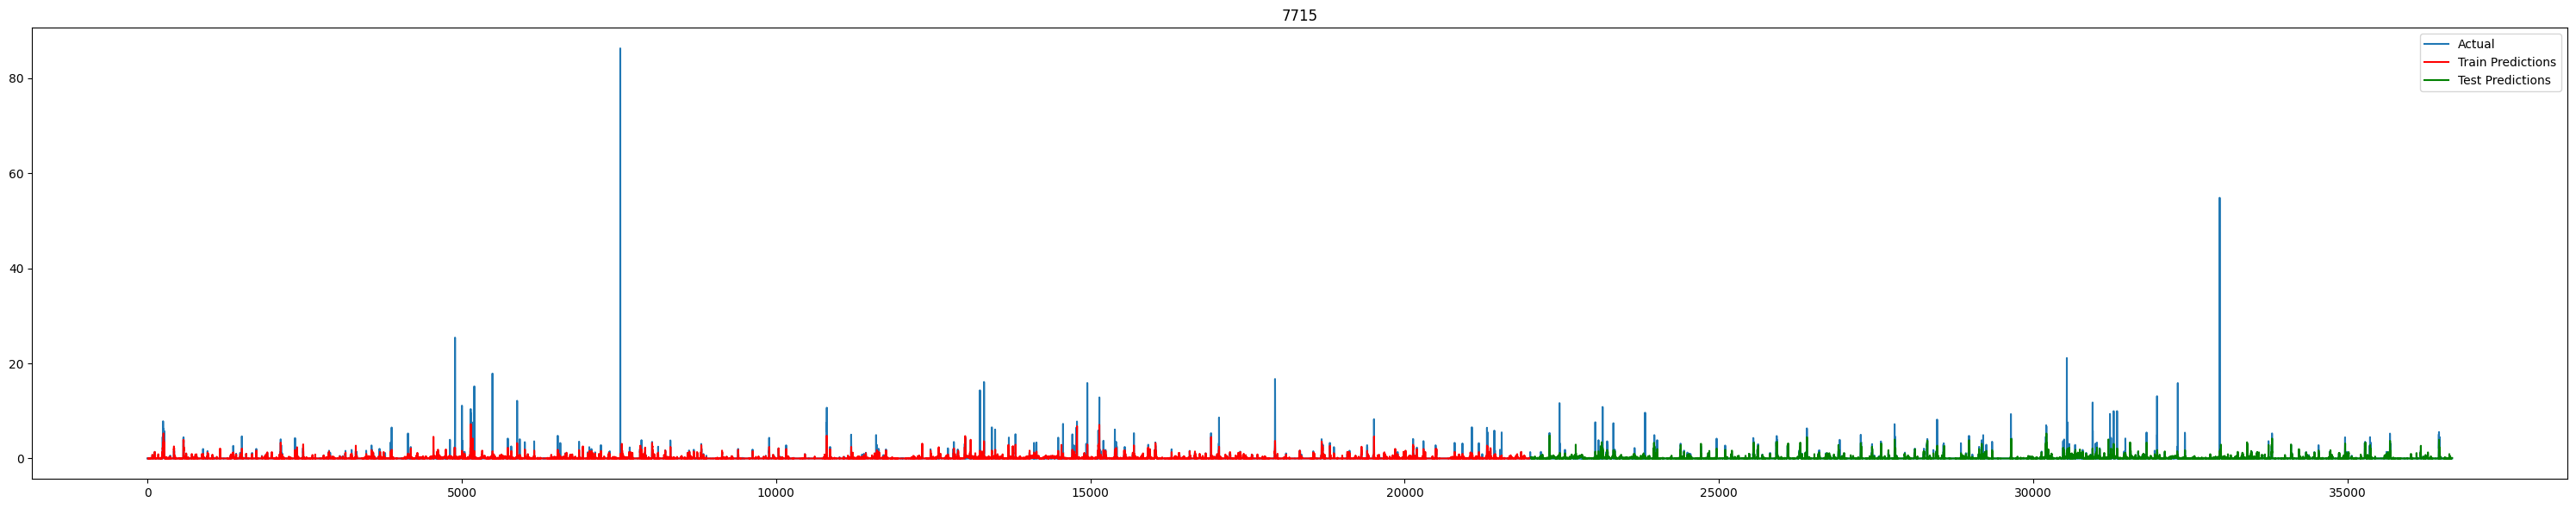

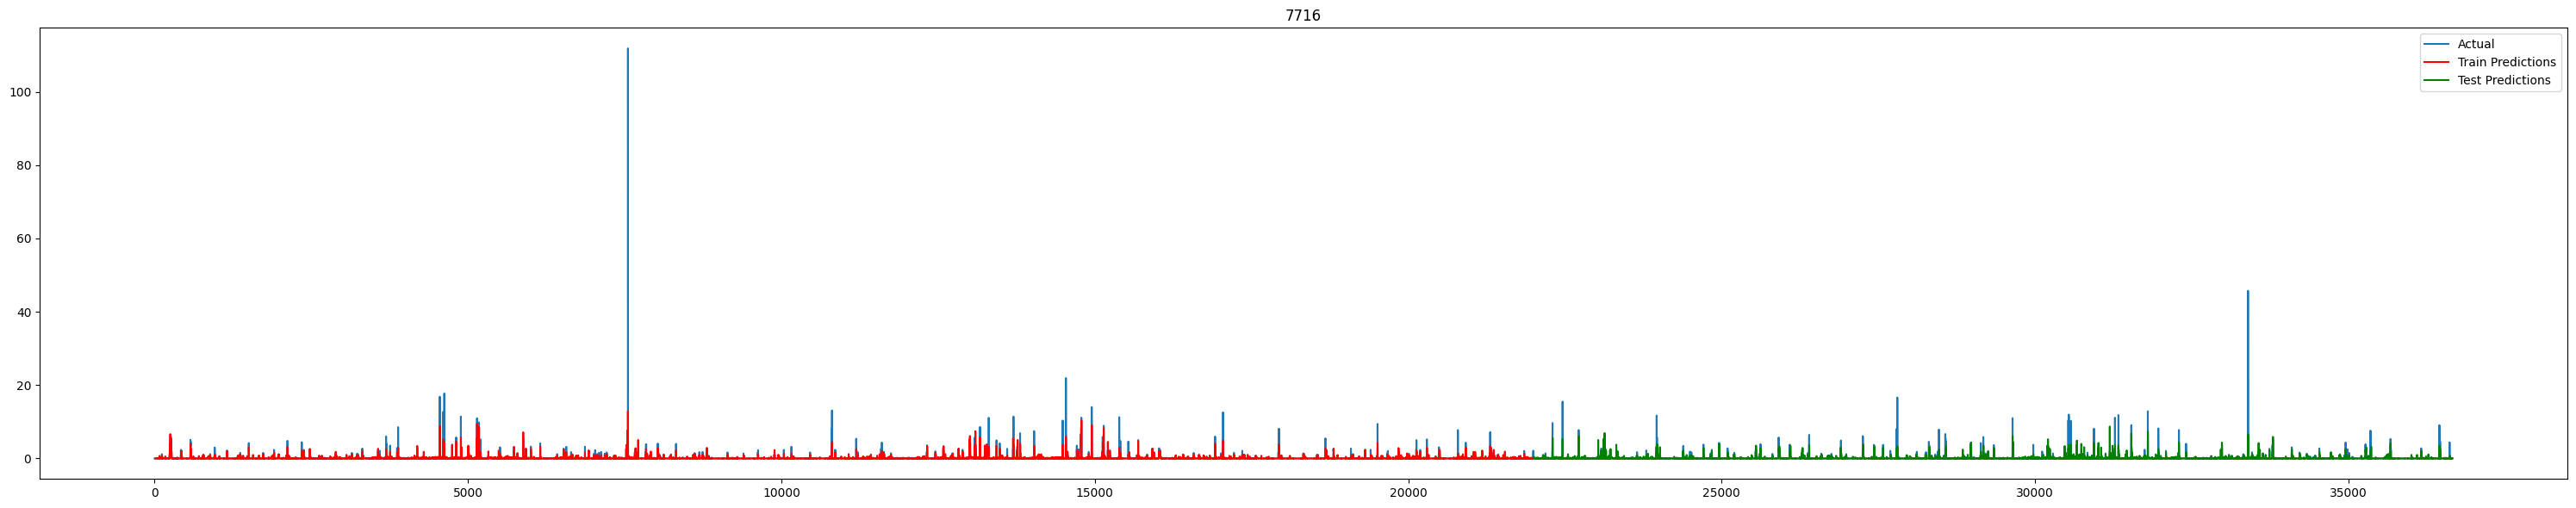

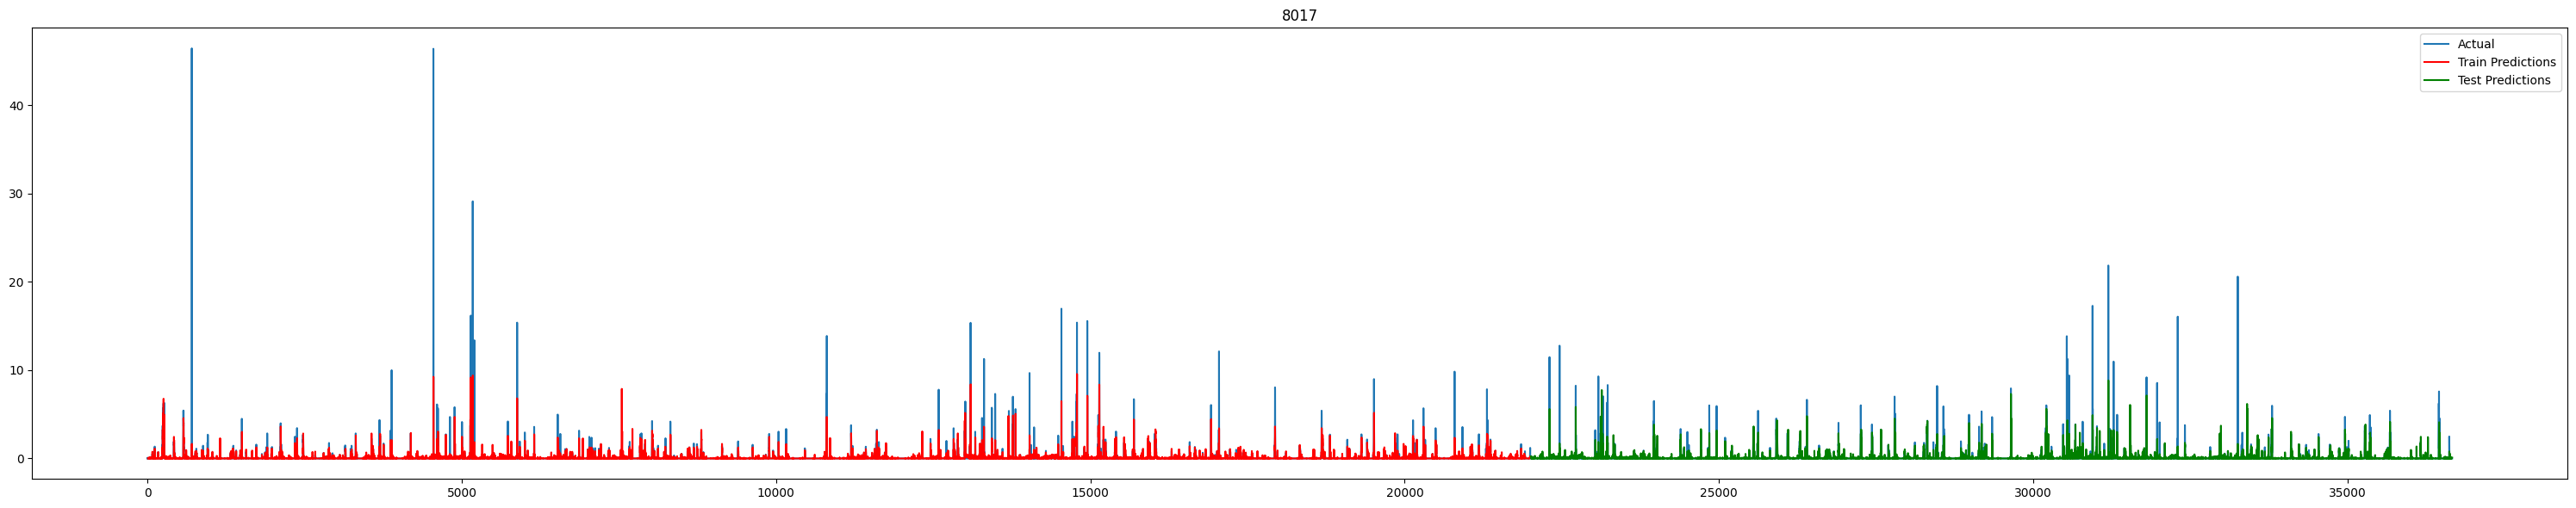

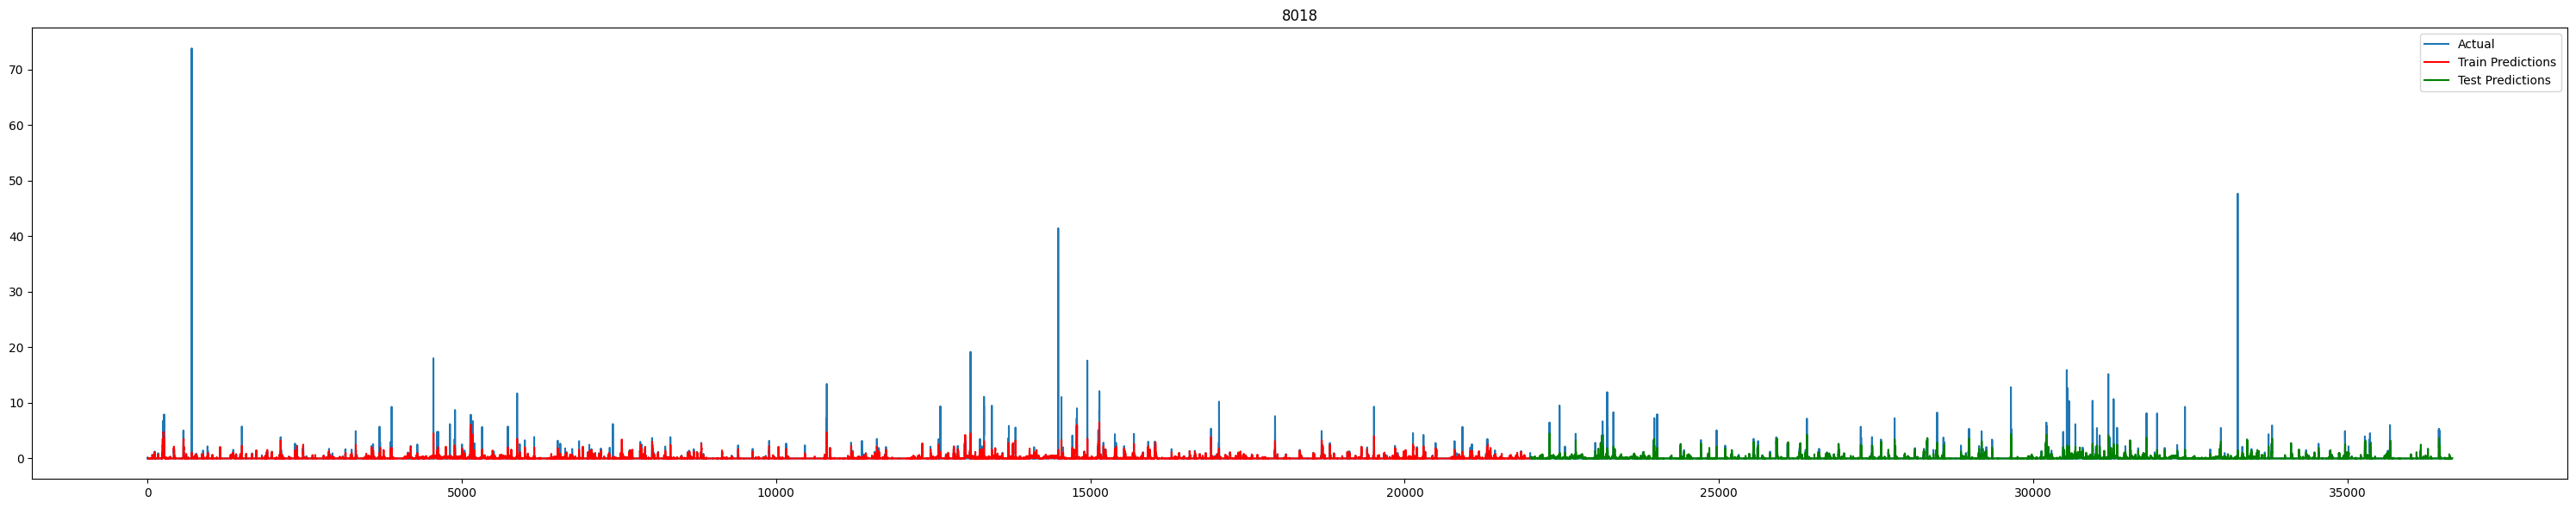

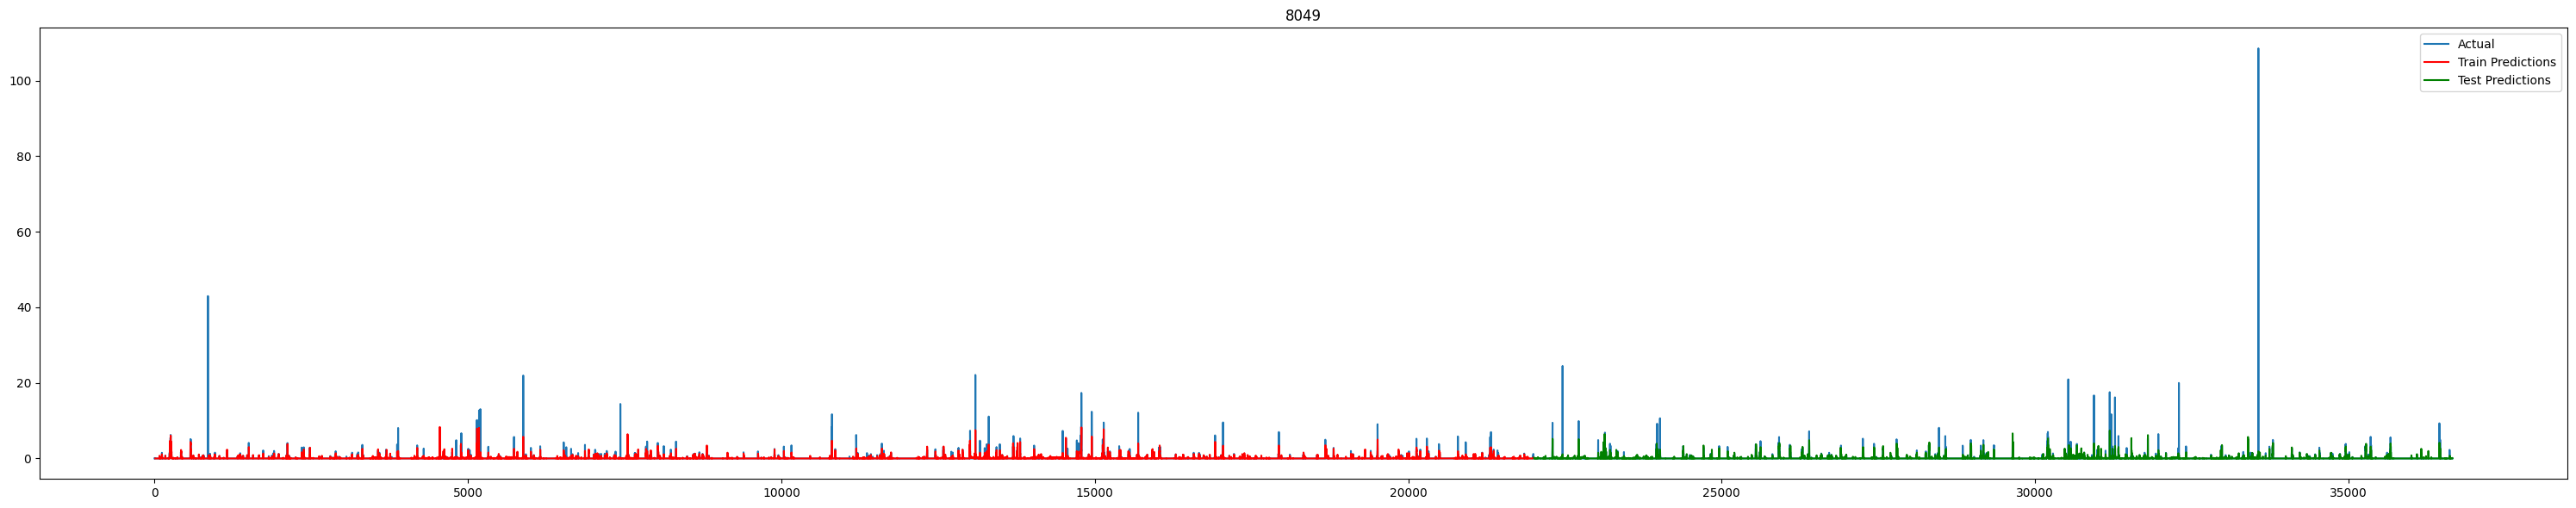

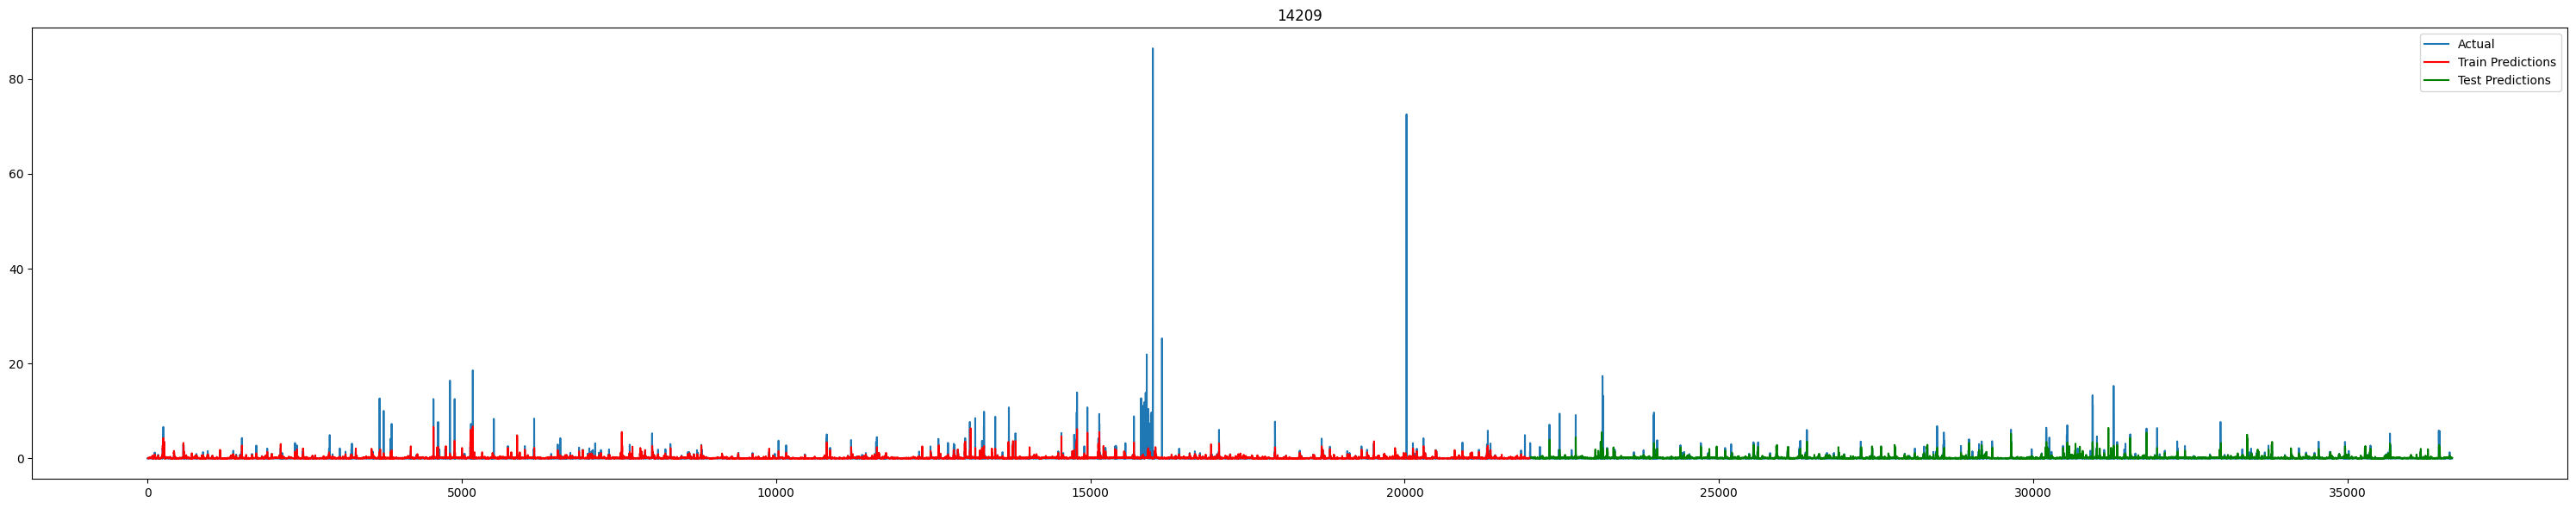

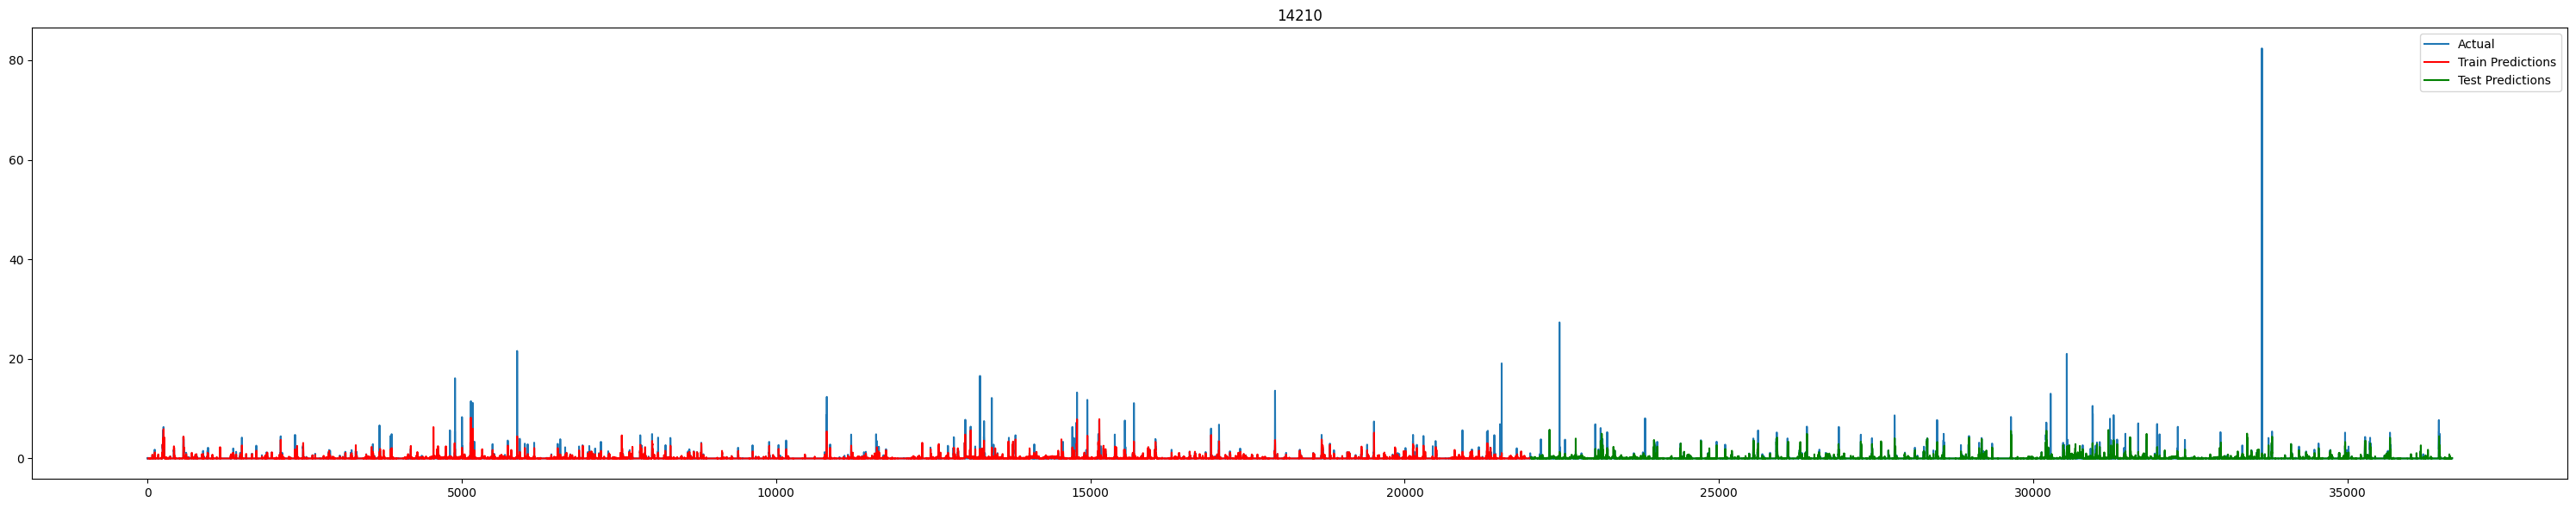

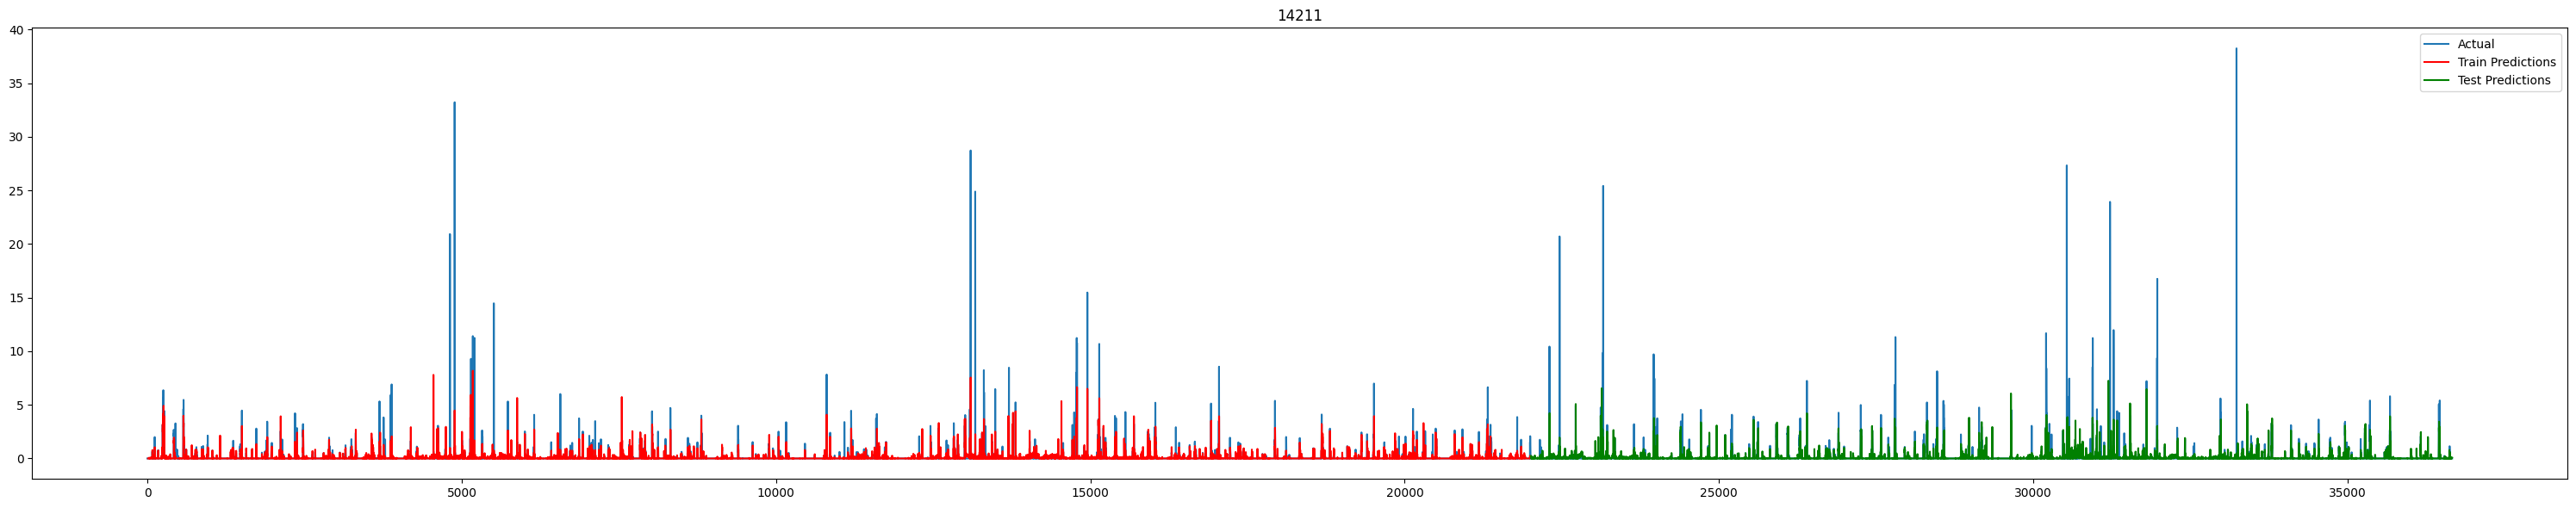

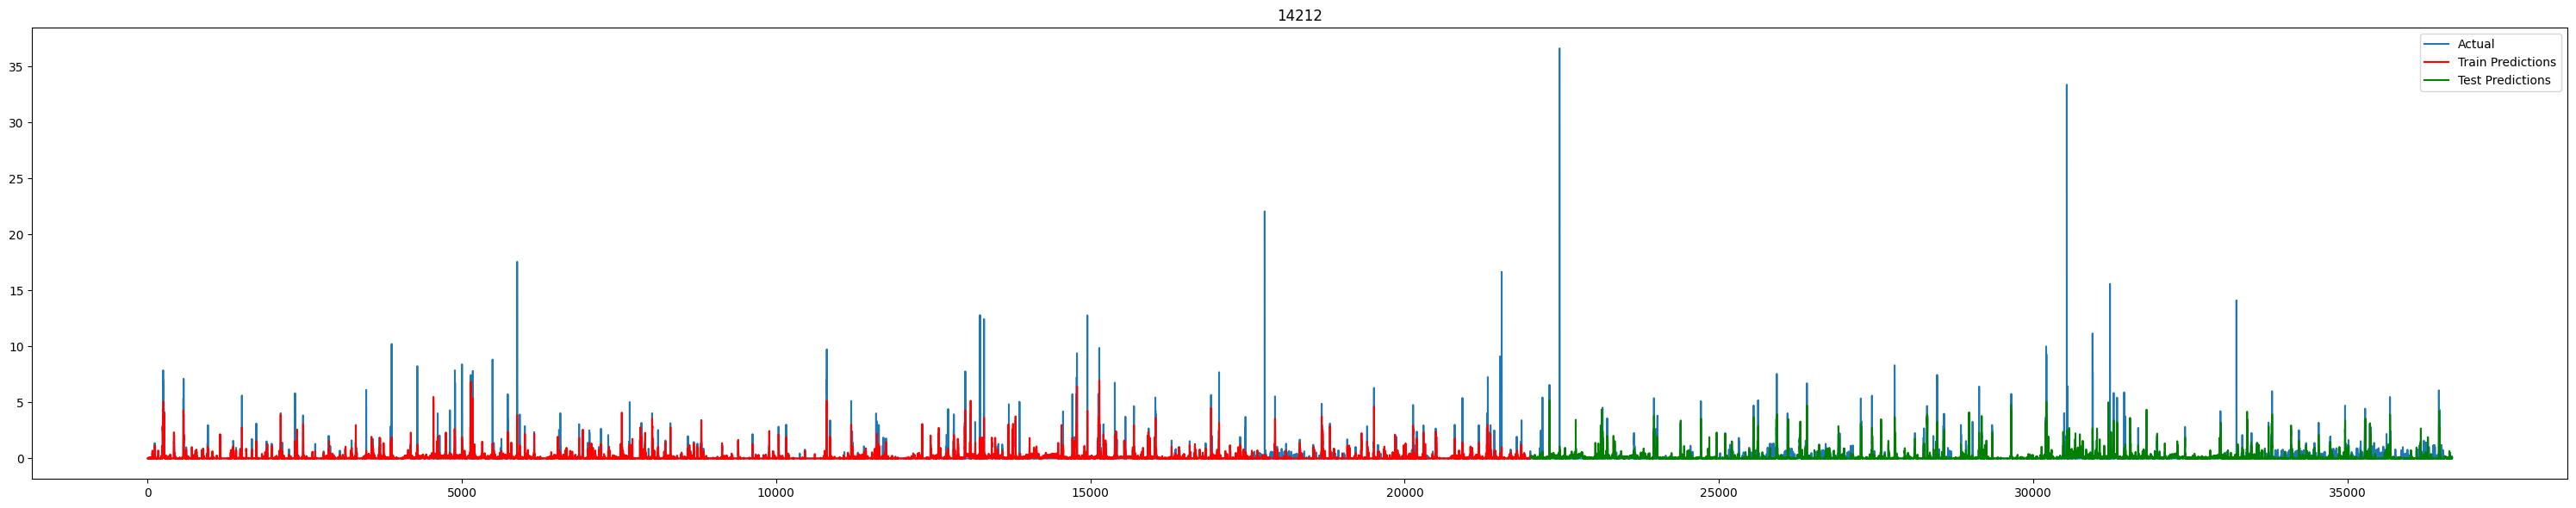

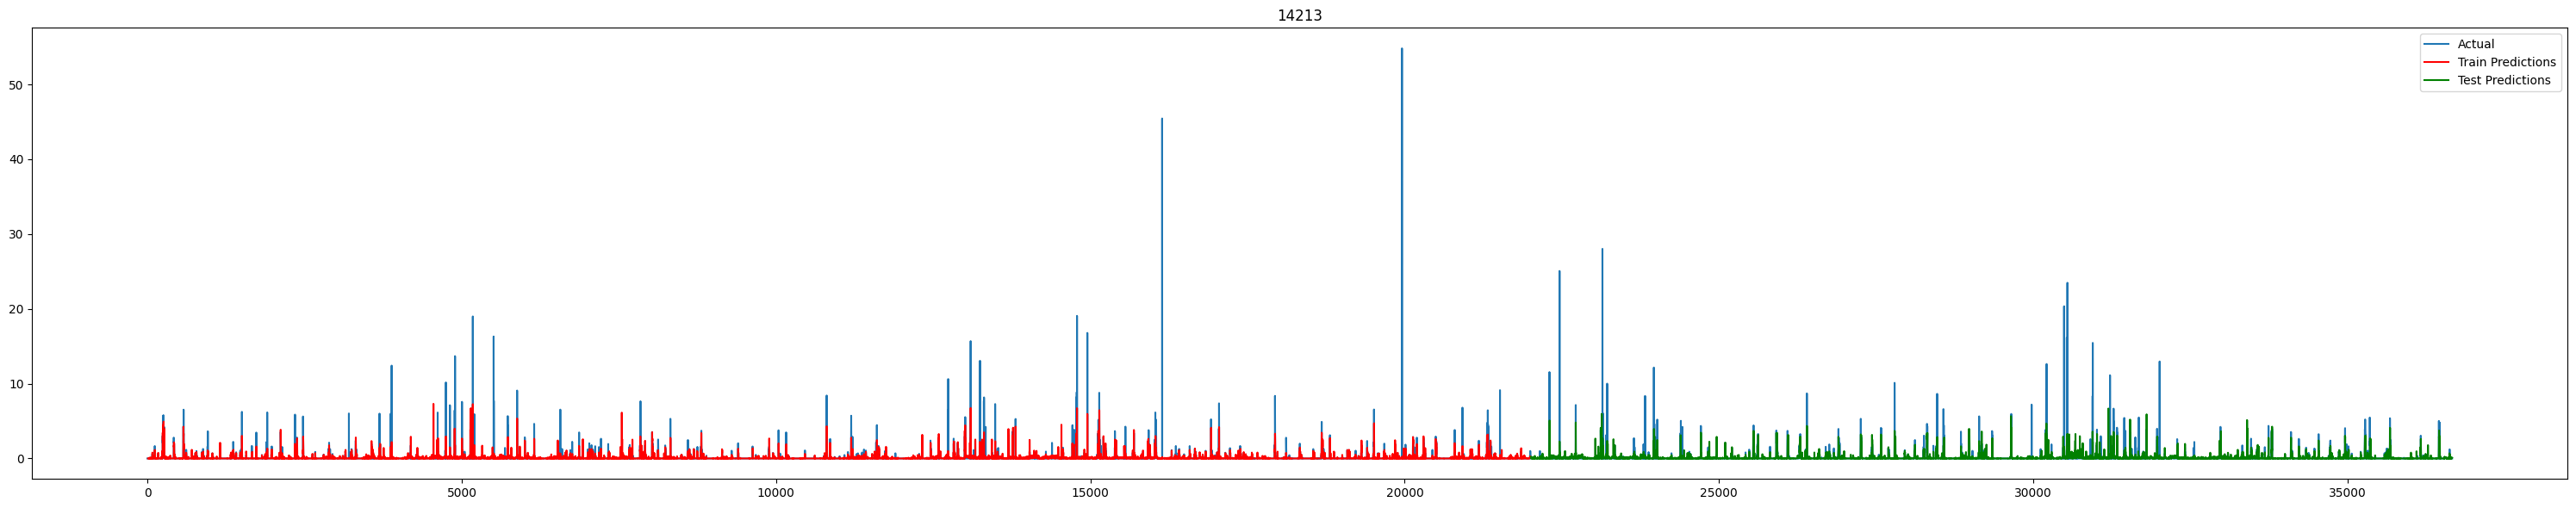

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import sklearn.metrics as sk

# Load the data
df = pd.read_csv('FullWeatherData_Toronto.csv')

# Extract input columns and output columns
input_cols = df.columns[:-4]
output_cols = []

for c in df.columns:
    if c.isdigit():
        output_cols.append(c)

# Convert the dataframe to a numpy array
timeseries = df[input_cols].values.astype('float32')

print(timeseries.shape)

# Train-test split for time series
train_size = int(len(timeseries) * 0.6)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

# Function to create dataset for multi-time step prediction
def create_dataset(dataset, lookback, n_steps, total_features, output_features):
    X, y = [], []
    total_features_list = list(total_features)
    output_indices = [total_features_list.index(feature) for feature in output_features]
    for i in range(len(dataset) - lookback - n_steps + 1):
        X.append(dataset[i:i + lookback, :])
        y.append(dataset[i + lookback:i + lookback + n_steps, output_indices])
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

# Parameters for dataset creation
lookback = 10
n_steps = 6  # Number of future time steps to predict

# Create training and test datasets
X_train, y_train = create_dataset(train, lookback=lookback, n_steps=n_steps, total_features=input_cols, output_features=output_cols)
X_test, y_test = create_dataset(test, lookback=lookback, n_steps=n_steps, total_features=input_cols, output_features=output_cols)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Define the LSTM model
class AirModel(nn.Module):
    def __init__(self, input_sz, hidden_sz, output_sz, n_steps, dropout_prob=0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_sz, hidden_size=hidden_sz, num_layers=2, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.linear = nn.Linear(hidden_sz, output_sz * n_steps)
        self.output_sz = output_sz
        self.n_steps = n_steps

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])  # Use the output of the last time step
        x = self.linear(x)
        x = torch.relu(x)
        x = x.view(-1, self.n_steps, self.output_sz)  # Ensure correct output shape
        return x

# Model parameters
input_size = len(input_cols)
output_size = len(output_cols)
model = AirModel(input_size, hidden_sz=50, output_sz=output_size, n_steps=n_steps, dropout_prob=0.1)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

print("output size:", output_size)
print("Train samples", train_size)

# Training loop
n_epochs = 30
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 2 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            train_loss = loss_fn(y_pred_train, y_train)
            train_rmse = torch.sqrt(train_loss)
            train_mae = torch.mean(torch.abs(y_pred_train - y_train))
            train_r2 = sk.r2_score(y_train.numpy().flatten(), y_pred_train.numpy().flatten())

            y_pred_test = model(X_test)
            test_loss = loss_fn(y_pred_test, y_test)
            test_rmse = torch.sqrt(test_loss)
            test_mae = torch.mean(torch.abs(y_pred_test - y_test))
            test_r2 = sk.r2_score(y_test.numpy().flatten(), y_pred_test.numpy().flatten())

            print(f"Epoch {epoch}: Train RMSE {train_rmse:.4f}, MAE {train_mae:.4f}, R^2 {train_r2:.4f} | Test RMSE {test_rmse:.4f}, MAE {test_mae:.4f}, R^2 {test_r2:.4f}")

# Plotting
with torch.no_grad():
    # Extract predictions
    y_pred_train = model(X_train).numpy()
    y_pred_test = model(X_test).numpy()

    # Plot both train and test predictions on the same plot for each output variable
    for i, col in enumerate(output_cols):
        plt.figure(figsize=(30, 6))
        plt.plot(timeseries[:, i], label='Actual')  # Plot the actual data for the current output variable

        # Shift train predictions for plotting
        train_plot = np.ones_like(timeseries[:, i]) * np.nan
        for j in range(y_pred_train.shape[0]):
            train_plot[lookback + j:lookback + j + n_steps] = y_pred_train[j, :, i]
        plt.plot(train_plot, c='r', label='Train Predictions')

        # Shift test predictions for plotting
        test_plot = np.ones_like(timeseries[:, i]) * np.nan
        for j in range(y_pred_test.shape[0]):
            test_plot[train_size + lookback + j:train_size + lookback + j + n_steps] = y_pred_test[j, :, i]
        plt.plot(test_plot, c='g', label='Test Predictions')

        plt.title(col)
        plt.legend()
        plt.tight_layout()
        plt.show()

In [5]:
df = pd.read_csv("FullWeatherData_Toronto.csv")

input_cols = df.columns[:-4]
output_cols = []

for c in df.columns:
    if c.isdigit():
        output_cols.append(c)

timeseries = df[input_cols].values.astype("float32")

print(timeseries.shape)

(36662, 56)


In [6]:
train_size = int(len(timeseries) * 0.6)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback, n_steps, total_features, output_features):
    X, y = [], []
    total_features_list = list(total_features)
    output_indices = [total_features_list.index(feature) for feature in output_features]
    for i in range(len(dataset) - lookback - n_steps + 1):
        X.append(dataset[i:i+lookback, :])
        y.append(dataset[i+lookback: i+lookback+n_steps, output_indices])
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    return X, y

lookback = 10
n_steps = 6

X_train, y_train = create_dataset(train, lookback=lookback, n_steps=n_steps, total_features=input_cols, output_features=output_cols)

X_test, y_test = create_dataset(test, lookback=lookback, n_steps=n_steps, total_features=input_cols, output_features=output_cols)

print(f"X shape: {X_train.shape}")
print(f"y shape: {y_train.shape}")


X shape: torch.Size([21982, 10, 56])
y shape: torch.Size([21982, 6, 50])


In [7]:
class RNN(nn.Module):
    def __init__(self, input_sz, hidden_sz, output_sz, n_steps, dropout_prob = 0.1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_sz, hidden_size = hidden_sz, num_layers = 2, batch_first=True)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.linear = nn.Linear(hidden_sz, output_sz * n_steps)
        self.n_steps = n_steps
        self.output_sz = output_sz

    def forward(self,x):
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.linear(x)
        x = torch.relu(x)
        x = x.view(-1, self.n_steps, self.output_sz)
        return x
    
input_size = len(input_cols)
output_size = len(output_cols)
model = RNN(input_size, hidden_sz=50, output_sz=output_size, n_steps=n_steps, dropout_prob=0.1)

optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=32)

print(input_size)
print(output_size)

56
50


In [8]:
n_epochs = 30

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred  = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 2 == 0:
        model.eval()
        with torch.no_grad():
            y_pred_train = model(X_train)
            train_loss = loss_fn(y_pred_train, y_train)
            train_rmse = torch.sqrt(train_loss)
            print("Epoch: ", epoch, "Train RMSE: ", train_rmse.item())

        with torch.no_grad():
            y_pred_test = model(X_test)
            test_loss = loss_fn(y_pred_test, y_test)
            test_rmse = torch.sqrt(test_loss)
            print("Epoch: ", epoch, "Test RMSE: ", test_rmse.item())




Epoch:  0 Train RMSE:  0.742954671382904
Epoch:  0 Test RMSE:  0.845473051071167
Epoch:  2 Train RMSE:  0.7393763065338135
Epoch:  2 Test RMSE:  0.842458188533783
Epoch:  4 Train RMSE:  0.7375282049179077
Epoch:  4 Test RMSE:  0.84115070104599
Epoch:  6 Train RMSE:  0.7370138168334961
Epoch:  6 Test RMSE:  0.840883195400238
Epoch:  8 Train RMSE:  0.735883355140686
Epoch:  8 Test RMSE:  0.8410196304321289
Epoch:  10 Train RMSE:  0.734853982925415
Epoch:  10 Test RMSE:  0.8405523300170898
Epoch:  12 Train RMSE:  0.7338858246803284
Epoch:  12 Test RMSE:  0.8410031199455261
Epoch:  14 Train RMSE:  0.7331015467643738
Epoch:  14 Test RMSE:  0.840775728225708
Epoch:  16 Train RMSE:  0.7311201095581055
Epoch:  16 Test RMSE:  0.8402677178382874
Epoch:  18 Train RMSE:  0.7273670434951782
Epoch:  18 Test RMSE:  0.8407233953475952
Epoch:  20 Train RMSE:  0.7273507118225098
Epoch:  20 Test RMSE:  0.8412529826164246
Epoch:  22 Train RMSE:  0.7227571606636047
Epoch:  22 Test RMSE:  0.8418772220611572